# Temporal Difference Learning

In this tutorial lecture we will look at several examples and implementation of algorithms, all related to the idea of
_temporal difference learning_.

Temporal difference refers to a class of model-free Reinforcement Learning algorithms methods which learns by
_bootstrapping_. To get started, let's recall the TD[0] update for the value-function:

$$V(s) \leftarrow V(s) + \alpha[\overbrace{r+\gamma \underbrace{V(s')}_{\text{bootstrapping}}}^{\text{TD target}}-V(s)]$$

in which becomes clear that we use the current estimate of the value-function to perform the update, thus resulting in
a _biased_ procedure.

This update is a special case of the more general TD[n], which instead suggests to collect more than only 1 reward
sample, in order to find a "more reliable" update:

$$V(s) \leftarrow V(s) + \alpha[\overbrace{\underbrace{r+\gamma r'+\gamma^2 r''+\dots}_{n\text{ future rewards}}+\gamma^{n}\underbrace{V(s^{(n)})}_{\text{bootstrapping}}}^{\text{TD target}}-V(s)]$$

where you can see that the role of bootstrapping is milder, but this comes at the price of having to wait more steps
before updating the value-function estimate.

In its other limit case, where $n$ equals the number of steps in the episode, this is the Monte Carlo algorithm.

Therefore the Temporal Difference framework is very important and makes use of all the concepts you studied so far.

## Today's topics

- SARSA VS Q-learning
- TD fixed point
- Mountain Car environment & SARSA($\lambda$)

### Usual credits and imports


In [1]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

## TD[0] for q-functions: on-policy VS off-policy

In this section we will take a closer look at two very important algorithms, which are built around the q-function
estimation instead of the value-function. Those are examples of TD[0], hence they will use only 1 reward sample for the
update. The on-policy and off-policy versions of this algorithm are called respectively **SARSA** and **Q-learning**.

We will witness their main differences by solving the _Cliff Walking_ environment. This is a gridworld environment, with
a standard undiscounted ($\gamma = 1$) episodic task, in which there are 2 different regions:
- Walking region: any transition ending in one of the states in this region result in a reward of $-1$. Two states of
this region are marked as "start" and "goal": it is there that the episode _always_ begins and ends, respectively.
- The Cliff: any transition ending in one of the states in this region result in a reward of $-100$ and sends the agent
back to the "start" state.

Let's see the performance of the agents following SARSA and Q-learning algorithm, with $\epsilon$-greedy action
selection, $\epsilon=0.1$.


Definition of the parameters and size of the environment, setting start and goal states (y-axis reversed).


In [2]:
# world height
WORLD_HEIGHT = 4

# world width
WORLD_WIDTH = 12

# probability for exploration
EPSILON = 0.1

# step size
ALPHA = 0.5

# gamma for Q-Learning and Expected Sarsa
GAMMA = 1

# all possible actions
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3
ACTIONS = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]

# initial state action pair values
START = [3, 0]
GOAL = [3, 11]

- `step` function: definition of the Cliff region, placed in the lowest row (start and goal states excluded).

- `choose_action` implements the $\epsilon$-greedy strategy.


In [3]:
def step(state, action):
    i, j = state
    if action == ACTION_UP:
        next_state = [max(i - 1, 0), j]
    elif action == ACTION_LEFT:
        next_state = [i, max(j - 1, 0)]
    elif action == ACTION_RIGHT:
        next_state = [i, min(j + 1, WORLD_WIDTH - 1)]
    elif action == ACTION_DOWN:
        next_state = [min(i + 1, WORLD_HEIGHT - 1), j]
    else:
        assert False

    reward = -1
    # Hard-coded Cliff! - not the best...
    if (action == ACTION_DOWN and i == 2 and 1 <= j <= 10) or (action == ACTION_RIGHT and state == START):
        reward = -100
        next_state = START

    return next_state, reward


# choose an action based on epsilon greedy algorithm
def choose_action(state, q_value):
    if np.random.binomial(1, EPSILON) == 1:
        return np.random.choice(ACTIONS)
    else:
        # q_value is indexed by [row, column, action]
        values_ = q_value[state[0], state[1], :]
        # breaking ties randomly
        return np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])

SARSA implementation: also _expected SARSA_ algorithm can be chosen.

**SARSA** update rule:

$$ Q(s, a) \leftarrow Q(s, a) + \alpha[r + \gamma Q(s', a') - Q(s, a)] $$

where $a'=\begin{cases} \text{random action } \qquad \text{w. p. } \epsilon \\ \arg\max_x{Q(s', x)} \quad \text{w. p. } 1-\epsilon\end{cases}$

**Expected SARSA** update rule:

$$ Q(s, a) \leftarrow Q(s, a) + \alpha[r + \gamma \underbrace{\mathbb{E}_{a'}[Q(s', a')]}_{V(s')} - Q(s, a)] $$


In [4]:
# an episode with Sarsa
# @q_value: values for state action pair, will be updated
# @expected: if True, will use expected Sarsa algorithm
# @step_size: step size for updating
# @return: total rewards within this episode
def sarsa(q_value, expected=False, step_size=ALPHA):
    state = START
    action = choose_action(state, q_value)
    rewards = 0.0
    while state != GOAL:
        next_state, reward = step(state, action)
        next_action = choose_action(next_state, q_value)
        rewards += reward
        if not expected:
            target = q_value[next_state[0], next_state[1], next_action]
        else:
            # calculate the expected value of new state
            target = 0.0
            q_next = q_value[next_state[0], next_state[1], :]
            best_actions = np.argwhere(q_next == np.max(q_next))
            for action_ in ACTIONS:
                if action_ in best_actions:
                    # probability of optimal action: (1-eps)/(# of optimal actions) + eps/(# of actions)
                    target += ((1.0 - EPSILON) / len(best_actions) + EPSILON / len(ACTIONS)) * q_value[next_state[0], next_state[1], action_]
                else:
                    # probability of non-optimal action: eps/(# of actions)
                    target += EPSILON / len(ACTIONS) * q_value[next_state[0], next_state[1], action_]
        target *= GAMMA
        q_value[state[0], state[1], action] += step_size * (
                reward + target - q_value[state[0], state[1], action])
        state = next_state
        action = next_action
    return rewards

**Q-learning** update rule:

$$ Q(s, a) \leftarrow Q(s, a) + \alpha[r + \max_{a'}[\gamma Q(s', a')] - Q(s, a)] $$


In [5]:
# an episode with Q-Learning
# @q_value: values for state action pair, will be updated
# @step_size: step size for updating
# @return: total rewards within this episode
def q_learning(q_value, step_size=ALPHA):
    state = START
    rewards = 0.0
    while state != GOAL:
        action = choose_action(state, q_value)
        next_state, reward = step(state, action)
        rewards += reward
        # Q-Learning update
        q_value[state[0], state[1], action] += step_size * (
                reward + GAMMA * np.max(q_value[next_state[0], next_state[1], :]) -
                q_value[state[0], state[1], action])
        state = next_state
    return rewards

Function that prints the optimal action for each state, as given by the learned q-table.

It has been modified to return `optimal_policy`.


In [6]:
# print optimal policy
def print_optimal_policy(q_value):
    optimal_policy = []  # empty list
    for i in range(0, WORLD_HEIGHT):
        optimal_policy.append([])  # empty list for each row
        for j in range(0, WORLD_WIDTH):  # for each column append the best action or 'G'
            if [i, j] == GOAL:
                optimal_policy[-1].append('G')
                continue
            bestAction = np.argmax(q_value[i, j, :])
            if bestAction == ACTION_UP:
                optimal_policy[-1].append('U')
            elif bestAction == ACTION_DOWN:
                optimal_policy[-1].append('D')
            elif bestAction == ACTION_LEFT:
                optimal_policy[-1].append('L')
            elif bestAction == ACTION_RIGHT:
                optimal_policy[-1].append('R')
    for row in optimal_policy:
        print(row)
    # return the optimal policy (according to the given q_value!)
    return optimal_policy

New function that prints the environment (in a very simple way).

It can also plot the path of the optimal policy returned by the previous function, with a user-defined label. You need
to pass as arguments the optimal policy and the label.


In [7]:
def print_env(optimal_policy=None, name=None):
    env = [['W']*WORLD_WIDTH for _ in range(WORLD_HEIGHT-1)]
    last_row = ['C']*WORLD_WIDTH
    last_row[0], last_row[WORLD_WIDTH-1] = 'S', 'G'
    env.append(last_row)
    if optimal_policy is not None:
        state = np.copy(START)
        while tuple(state) != tuple(GOAL):
            env[state[0]][state[1]] = name
            if optimal_policy[state[0]][state[1]] == 'U':
                state[0] -= 1
            elif optimal_policy[state[0]][state[1]] == 'R':
                state[1] += 1
            elif optimal_policy[state[0]][state[1]] == 'D':
                state[0] += 1
            elif optimal_policy[state[0]][state[1]] == 'L':
                state[1] -= 1
    env[START[0]][START[1]] = 'S'
    [print(env[i]) for i in range(len(env))]

Let's execute the SARSA and Q-learning algorithm for 10 runs of 500 episodes each and see their optimal paths.


Environment representation:
['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W']
['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W']
['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W']
['S', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'G']


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.23it/s]

Sarsa Optimal Policy:
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['U', 'U', 'L', 'U', 'U', 'U', 'U', 'R', 'U', 'U', 'R', 'D']
['U', 'R', 'R', 'U', 'U', 'R', 'U', 'R', 'U', 'U', 'R', 'D']
['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'G']
Sarsa optimal path (label 'A'):
['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A']
['A', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'A']
['A', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'A']
['S', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'G']
Q-Learning Optimal Policy:
['R', 'R', 'R', 'R', 'L', 'R', 'D', 'R', 'R', 'D', 'D', 'D']
['U', 'D', 'R', 'D', 'D', 'R', 'R', 'D', 'R', 'R', 'D', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'G']
Q-learning optimal path (label 'Q'):
['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W']
['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W']
['Q', 'Q', 'Q', 'Q', 'Q', 'Q

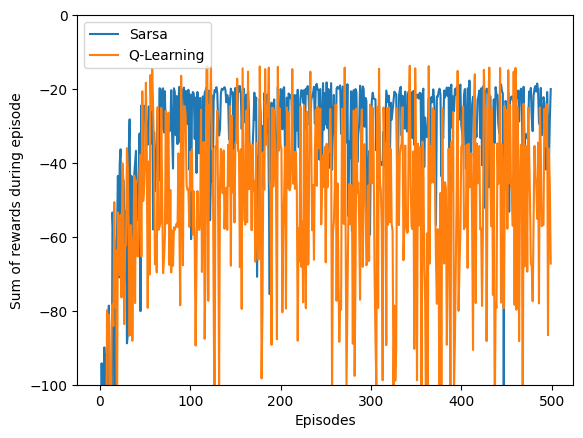

In [8]:
print('Environment representation:')
print_env()

# episodes of each run
episodes = 500

# perform 10 independent runs
runs = 10

rewards_sarsa = np.zeros(episodes)
rewards_q_learning = np.zeros(episodes)
for r in tqdm(range(runs)):  # every time I start with a new q_table (I will print only the last one)
    q_sarsa = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
    q_q_learning = np.copy(q_sarsa)
    for i in range(0, episodes):
        # cut off the value by -100 to draw the figure more elegantly
        # rewards_sarsa[i] += max(sarsa(q_sarsa), -100)
        # rewards_q_learning[i] += max(q_learning(q_q_learning), -100)
        rewards_sarsa[i] += sarsa(q_sarsa)
        rewards_q_learning[i] += q_learning(q_q_learning)

# averaging over independent runs
rewards_sarsa /= runs
rewards_q_learning /= runs

# display optimal policy
print('Sarsa Optimal Policy:')
opt_sarsa = print_optimal_policy(q_sarsa)
print('Sarsa optimal path (label \'A\'):')
print_env(opt_sarsa, 'A')
print('Q-Learning Optimal Policy:')
opt_q = print_optimal_policy(q_q_learning)
print('Q-learning optimal path (label \'Q\'):')
print_env(opt_q, 'Q')

# draw reward curves
plt.plot(rewards_sarsa, label='Sarsa')
plt.plot(rewards_q_learning, label='Q-Learning')
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episode')
plt.ylim([-100, 0])
plt.legend()

plt.show()
plt.close()

## TD fixed point

Until now, we always considered the case in which the number of states is rather small, so that we could estimate the
actual value-function or q-function for each state without much computational effort. This is rarely the case in actual
Reinforcement Learning, therefore it is essential to address also the case of function approximation.

In general, we want to describe the quantity of interest (the value or q-function) with a smaller number of "degrees of
freedom" than the number of all possible state $\vert \mathcal{S}\vert$, and in order to do that we exploit a _parametrized functional form_.
This means that we will express our quantity of interest with a **parameter** $w \in \mathbb{R}^d$ (or better a vector of parameters) which
uniquely describe a particular function $f \in \mathcal{F}_w$.

Then our best approximation will of course belong to this space of functions $\mathcal{F}_w$ (given by the functions
that can be described by a particular paramter $w$), and indeed this is the "simplification" we are introducing in the
problem: we are searching in a smaller space $\mathcal{F}_w \subset \mathcal{F}$, reducing the dimensionality from
$\vert \mathcal{S}\vert$ to $d$, with $d<<\vert \mathcal{S}\vert$.

Consider the **linear** function space. Given the $d$ dimensional _fixed_ feature vector

$$ x(s) = (x_1(s), x_2(s), \dots, x_d(s)) $$

we want to find the best $w = (w_1, \dots, w_d)$ so that the prediction objective ($\overline{\text{VE}}$) is minimized, given the linear functional form: $\hat{v}(s, w)=w^\top x(s)$.

Recall that the prediction objective is the norm of the difference of our approximation and the true value-function,
weighted by a state distribution $\mu(s)$, i.e.:

$$\overline{\text{VE}}(w) = \sum_{s\in\mathcal{S}}\mu(s)[v_\pi(s) - \hat{v}(s, w)]^2$$

A simple strategy to minimize this objective is the SGD algorithm, which yields the update:

$$ w_{t+1} = w_t + \alpha[U_t - \hat{v}(s_t, w_t)]x(s_t)$$

since $\nabla_w\hat{v}(s, w) = x(s)$. Pay attention: for this update to hold exactly, the target $U_t$ must not depend on $w$!
Otherwise, the derivative of that term is also implied! If the latter is neglected, we call it a semi-gradient update.

As you know, the TD algorithm uses bootstrapping, and therefore the target depends on the current estimate, which of
course depends on $w$. Thus we have a semi-gradient update, that does not converges to the global optimum (which is
attained by following the Monte Carlo algorithm, for example), but to the so-called _TD fixed point_.

It can be proved that the prediction objective at the TD fixed point is lower bounded by:

$$ \overline{\text{VE}}(w_{\text{TD}}) \leq \frac{1}{1-\gamma}\overline{\text{VE}}(w) $$

We will verify how bad the _TD fixed point_ can be in the case of "maximum bootstrapping", i.e. $\gamma = 1$, (in which the prediction objective can grow unbounded) with the 1000-state Random Walk environment.

1000-state **Random Walk environment**:
- Start in state 500
- Actions: left or right randomly (policy is embedded in the environment)
- For every transition there is an equal probability of terminating in the next 100 states (in the direction of the
action), always with $0$ reward. If there are less than 100 states the probability is accumulated in the last state.
- Termination on the left: -1 reward
- Termination on the right: +1 reward

Definition of the parameters and functioning of the environment through the `step` function. The policy is random as
`get_action` returns a random action; the function `compute_true_value` computes the true value-function with Dynamic Programming.

In [9]:
# # of states except for terminal states
N_STATES = 1000

# all states
STATES = np.arange(1, N_STATES + 1)

# start from a central state
START_STATE = 500

# terminal states
END_STATES = [0, N_STATES + 1]

# possible actions
ACTION_LEFT = -1
ACTION_RIGHT = 1
ACTIONS = [ACTION_LEFT, ACTION_RIGHT]

# maximum stride for an action
STEP_RANGE = 100


def compute_true_value():
    # true state value, just a promising guess
    true_value = np.arange(-1001, 1003, 2) / 1001.0
    assert (np.arange(-1001, 1003, 2) == np.arange(-1001, 1002, 2)).all()

    # Dynamic programming to find the true state values, based on the promising guess above
    # Assume all rewards are 0, given that we have already given value -1 and 1 to terminal states
    while True:
        old_value = np.copy(true_value)
        for state in STATES:
            true_value[state] = 0
            for action in ACTIONS:
                for step in range(1, STEP_RANGE + 1):
                    step *= action  # step with sign
                    next_state = state + step
                    next_state = max(min(next_state, N_STATES + 1), 0)  # to clip the boundaries
                    # asynchronous update for faster convergence
                    # probability is 1/200 because of random action - estimating v_\pi!
                    true_value[state] += 1.0 / (2 * STEP_RANGE) * true_value[next_state]
        error = np.sum(np.abs(old_value - true_value))
        if error < 1e-2:
            break
    # correct the state value for terminal states to 0
    true_value[0] = true_value[-1] = 0

    return true_value


# take an @action at @state, return new state and reward for this transition
def step(state, action):
    step = np.random.randint(1, STEP_RANGE + 1)
    step *= action
    state += step
    state = max(min(state, N_STATES + 1), 0)
    if state == 0:
        reward = -1
    elif state == N_STATES + 1:
        reward = 1
    else:
        reward = 0
    return state, reward


# get an action, following random policy
def get_action():
    if np.random.binomial(1, 0.5) == 1:
        return 1
    return -1

A general class for value-function with function approximation: grouping different states together. The dimensionality in this case is reduced from 1000 to `num_of_groups` (which will be then taken equal to 10). We will use a 1-dimensional tile coding approximation, which corresponds to a coarser grid for discrete values (or to a grouping of the finer grid). If $(S_1, S_2, \dots, S_d)$ are the groups, the feature vector is built through the scalar functions $x_i(s) = \mathbb{1}_{S_i}(s)$.


The class below will automatically take care of the grouping and approximation, thus allowing us to treat the value-function as we have always done, i.e. passing the state without pre-processing.

In [10]:
# a wrapper class for aggregation value function
class ValueFunction:
    # @num_of_groups: # of aggregations
    def __init__(self, num_of_groups):
        self.num_of_groups = num_of_groups  #  dimension of the feature vector d
        self.group_size = N_STATES // num_of_groups

        # thetas
        self.params = np.zeros(num_of_groups)

    # get the value of @state
    def value(self, state):
        if state in END_STATES:
            return 0
        group_index = (state - 1) // self.group_size
        return self.params[group_index]  # collective value of the group (to which the state belongs) is returned!

    # update parameters
    # @delta: step size * (target - old estimation)
    # @state: state of current sample
    def update(self, delta, state):
        group_index = (state - 1) // self.group_size
        self.params[group_index] += delta

We want to understand the role of the TD fixed point, so we need to compare its prediction objective to the global
optimum. To reach the latter point, we use the Monte Carlo algorithm (which is unbiased, and its target does not depend
on $w$).

SGD for **Monte Carlo** scheme:
$$ w_{t+1} = w_t + \alpha[G_t - \hat{v}(s_t, w_t)]\nabla_w\hat{v}(s_t, w_t) $$

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:25<00:00, 3947.16it/s]


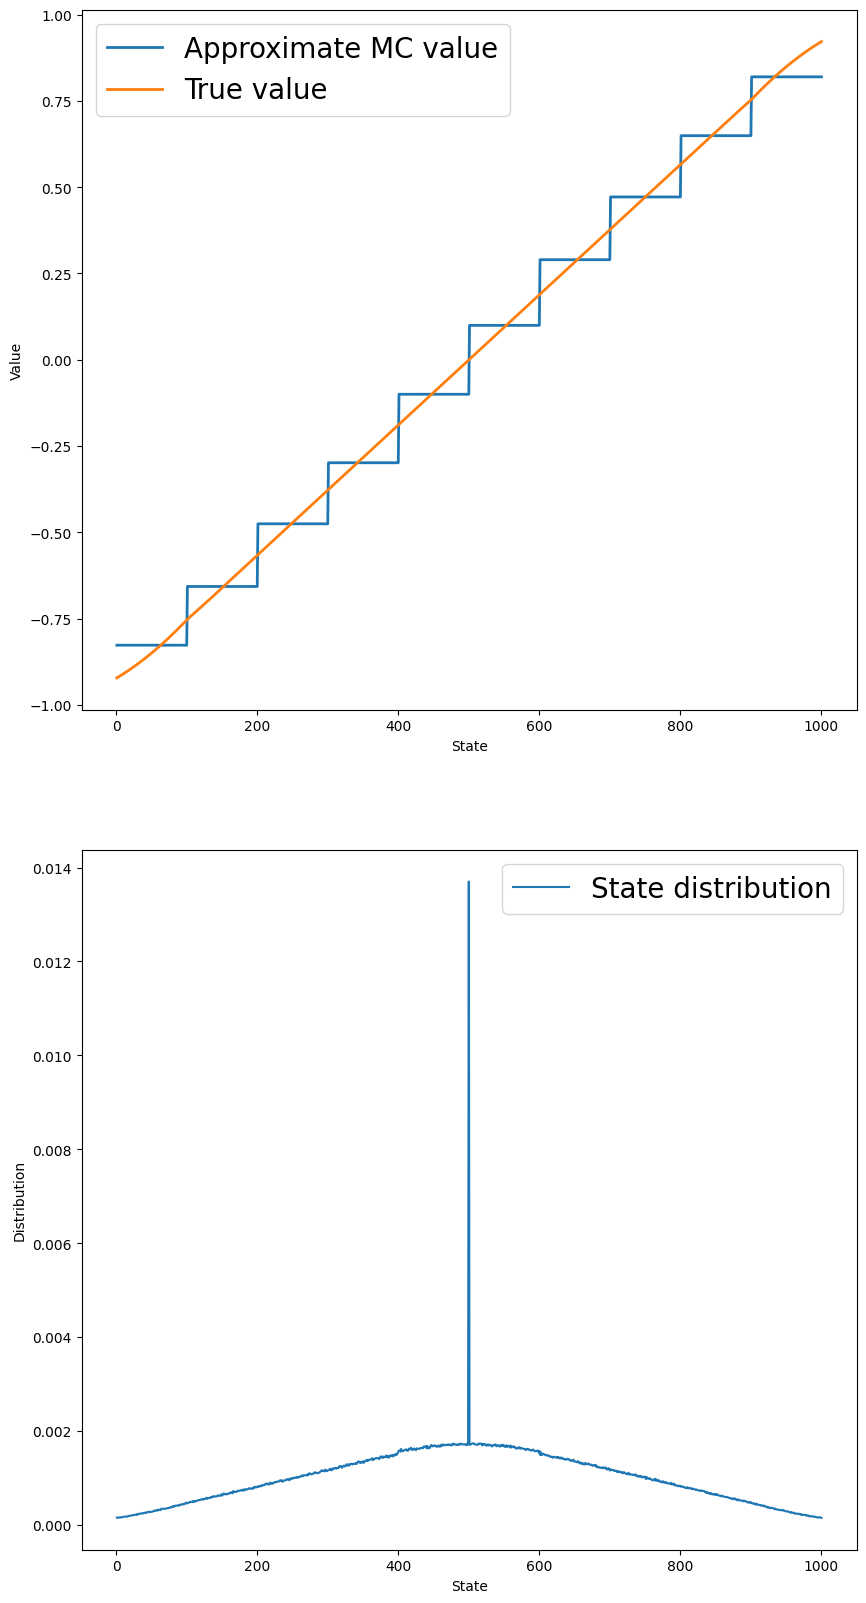

In [11]:
# gradient Monte Carlo algorithm
# @value_function: an instance of class ValueFunction
# @alpha: step size
# @distribution: array to store the distribution statistics
def gradient_monte_carlo(value_function, alpha, distribution=None):
    state = START_STATE
    trajectory = [state]

    # We assume gamma = 1, so return is just the same as the latest reward
    reward = 0.0
    while state not in END_STATES:
        action = get_action()
        next_state, reward = step(state, action)  # @reward keeps updating!
        trajectory.append(next_state)
        state = next_state

    # Gradient update for each state in this trajectory
    for state in trajectory[:-1]:  # parse the trajectory backward
        delta = alpha * (reward - value_function.value(state))  # Monte Carlo!
        value_function.update(delta, state)
        if distribution is not None:
            distribution[state] += 1  # also empirical distribution is provided


true_value = compute_true_value()

episodes = int(1e5)
alpha = 2e-5

# we have 10 aggregations in this example, each has 100 states
value_function = ValueFunction(10)
distribution = np.zeros(N_STATES + 2)
for ep in tqdm(range(episodes)):
    gradient_monte_carlo(value_function, alpha, distribution)

distribution /= np.sum(distribution)  # normalize distribution
state_values = [value_function.value(i) for i in STATES]  # get values for each state

plt.figure(figsize=(10, 20))

plt.subplot(2, 1, 1)
plt.plot(STATES, state_values, label='Approximate MC value', linewidth=2)
plt.plot(STATES, true_value[1: -1], label='True value', linewidth=2)
plt.xlabel('State')
plt.ylabel('Value')
plt.legend(prop={"size":20})

plt.subplot(2, 1, 2)
plt.plot(STATES, distribution[1: -1], label='State distribution')
plt.xlabel('State')
plt.ylabel('Distribution')
plt.legend(prop={"size":20})

plt.show()
plt.close()


Then we must implement the TD semi-gradient method. We will look at the more general TD[n].

SGD for **TD[n]** method:
$$w_{t+1} = w_t + \alpha[r+r'+r''+\dots+\hat{v}(s_{t+n}, w_t)-\hat{v}(s_t, w_t)]\nabla_w\hat{v}(s_t, w_t) $$

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:32<00:00, 3084.56it/s]


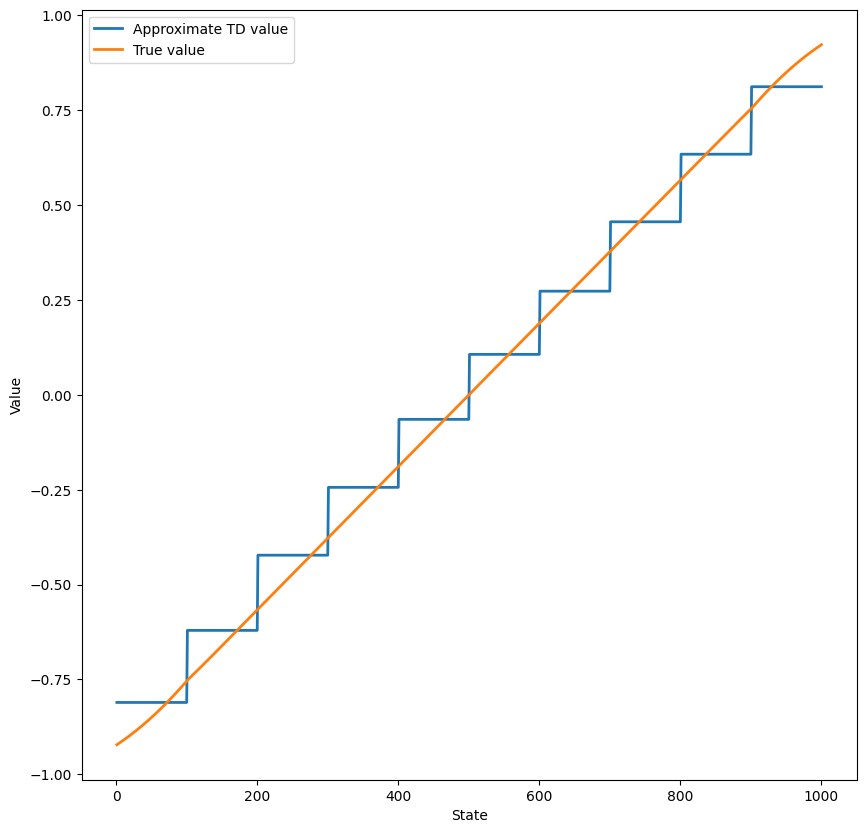

In [12]:
# semi-gradient n-step TD algorithm
# @valueFunction: an instance of class ValueFunction
# @n: # of steps
# @alpha: step size
def semi_gradient_temporal_difference(value_function, n, alpha):
    # initial starting state
    state = START_STATE

    # arrays to store states and rewards for an episode
    # space isn't a major consideration, so I didn't use the mod trick
    states = [state]
    rewards = [0]  # never using these values

    # track the time
    time = 0

    # the length of this episode
    T = float('inf')
    while True:
        # go to next time step
        time += 1

        if time < T:
            # choose an action randomly
            action = get_action()
            next_state, reward = step(state, action)

            # store new state and new reward
            states.append(next_state)
            rewards.append(reward)

            if next_state in END_STATES:
                T = time

        # get the time of the state to update
        update_time = time - n
        if update_time >= 0:
            returns = 0.0
            # calculate corresponding rewards
            for t in range(update_time + 1, min(T, update_time + n) + 1):
                returns += rewards[t]
            # add state value to the return
            if update_time + n <= T:  # bootstrapping
                # I believe < is correct, not <=, but since value returns 0 in END_STATES is actually the same
                returns += value_function.value(states[update_time + n])
            state_to_update = states[update_time]
            # update the value function
            if not state_to_update in END_STATES:
                delta = alpha * (returns - value_function.value(state_to_update))
                value_function.update(delta, state_to_update)
        if update_time == T - 1:
            break
        state = next_state


episodes = int(1e5)
alpha = 2e-4
value_function = ValueFunction(10)
for ep in tqdm(range(episodes)):
    semi_gradient_temporal_difference(value_function, 5, alpha)

stateValues = [value_function.value(i) for i in STATES]

plt.figure(figsize=(10, 10))

plt.plot(STATES, stateValues, label='Approximate TD value', linewidth=2)
plt.plot(STATES, true_value[1: -1], label='True value', linewidth=2)
plt.xlabel('State')
plt.ylabel('Value')
plt.legend()

Try and change the value of $n$ to see the difference.

## Mountain Car

Let's play a bit with the Mountain Car environment to see the standard syntax for dealing with general pre-built environments (this will also be what people will expect to see if there is a need to code an environment from scratch).

We will use the environment already built by gym, thus we need to import (and first install, if you do not have it) the gym module.

In [13]:
%pip install gym==0.15.3

Defaulting to user installation because normal site-packages is not writeable
--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/console.py", line 1673, in print
    extend(render(renderable, render_options))
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/console.py", line 1305, in render
    for render_output in iter_render:
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/segment.py", line 249, in split_lines
    for segment in segments:
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/console.py", line 1283, in render
    renderable = rich_cast(renderable)
  File 

In [14]:
from math import floor
import gym
from gym import wrappers  # disregard this line

In [15]:
car_env = gym.envs.make("MountainCar-v0")  # define the Mountain Car environment
car_env = wrappers.Monitor(car_env, "./gym-results", force=True)  # disregard this line
car_env.reset()  # You must perform this line! Try not to!

for _ in range(1000):
    action = 2  # action 1 does nothing
    observation, reward, done, info = car_env.step(action)
    # car_env.render()  # You will need this line to display the environmnent
    if done: break
car_env.close()

In [16]:
# This cell is there just to allows us to replay the video (at a slower pace)
import io
import base64
from IPython.display import HTML

video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % car_env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video width="600" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''.format(encoded.decode('ascii')))

Let's now use the **SARSA n-step algorithm** to learn the optimal q-function (and clearly also the value-function). Since it is a deterministic environment, the opimtistic initial value is enough to fully expore the environment and reach the optimal policy.

Below there is a different implementation of tilings than before, working with _action-value function_. The principle is the same (of course): you can still think of it as a mapping from states to groups, in order to reduce dimensionality. Features are indeed built again with the indicator function.

In [17]:
#######################################################################
# Following are some utilities for tile coding from Rich.
# To make each file self-contained, I copied them from
# http://incompleteideas.net/tiles/tiles3.py-remove
# with some naming convention changes
#
# Tile coding starts
class IHT:
    "Structure to handle collisions"
    def __init__(self, size_val):
        self.size = size_val
        self.overfull_count = 0
        self.dictionary = {}

    def count(self):
        return len(self.dictionary)

    def full(self):
        return len(self.dictionary) >= self.size

    def get_index(self, obj, read_only=False):
        d = self.dictionary
        if obj in d:
            return d[obj]
        elif read_only:
            return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfull_count == 0: print('IHT full, starting to allow collisions')
            self.overfull_count += 1
            return hash(obj) % self.size
        else:
            d[obj] = count
            return count

def hash_coords(coordinates, m, read_only=False):
    if isinstance(m, IHT): return m.get_index(tuple(coordinates), read_only)
    if isinstance(m, int): return hash(tuple(coordinates)) % m
    if m is None: return coordinates

def tiles(iht_or_size, num_tilings, floats, ints=None, read_only=False):
    """returns num-tilings tile indices corresponding to the floats and ints"""
    if ints is None:
        ints = []
    qfloats = [floor(f * num_tilings) for f in floats]
    tiles = []
    for tiling in range(num_tilings):
        tilingX2 = tiling * 2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append((q + b) // num_tilings)
            b += tilingX2
        coords.extend(ints)
        tiles.append(hash_coords(coords, iht_or_size, read_only))
    return tiles
# Tile coding ends
#######################################################################

Below we define the environment on which we will train the SARSA algorithm. It is a distinct environment from the previous one, but it works in the same way!

In [18]:
# all possible actions
ACTION_REVERSE = -1
ACTION_ZERO = 0
ACTION_FORWARD = 1
# order is important
ACTIONS = [ACTION_REVERSE, ACTION_ZERO, ACTION_FORWARD]

# bound for position and velocity
POSITION_MIN = -1.2
POSITION_MAX = 0.6
VELOCITY_MIN = -0.07
VELOCITY_MAX = 0.07

# use optimistic initial value, so it's ok to set epsilon to 0 - DETERMINISTIC ENVIRONMENT!
EPSILON = 0

# take an @action at @position and @velocity
# @return: new position, new velocity, reward (always -1)
def step(position, velocity, action):
    new_velocity = velocity + 0.001 * action - 0.0025 * np.cos(3 * position)  # physics model - not so accurate...
    new_velocity = min(max(VELOCITY_MIN, new_velocity), VELOCITY_MAX)
    new_position = position + new_velocity
    new_position = min(max(POSITION_MIN, new_position), POSITION_MAX)
    reward = -1.0
    if new_position == POSITION_MIN:
        new_velocity = 0.0
    return new_position, new_velocity, reward

# wrapper class for state action value function
class ValueFunction:
    # In this example I use the tiling software instead of implementing standard tiling by myself
    # One important thing is that tiling is only a map from (state, action) to a series of indices
    # It doesn't matter whether the indices have meaning, only if this map satisfy some property
    # View the following webpage for more information
    # http://incompleteideas.net/sutton/tiles/tiles3.html
    # @max_size: the maximum # of indices
    def __init__(self, step_size, num_of_tilings=8, max_size=2048):
        self.max_size = max_size
        self.num_of_tilings = num_of_tilings

        # divide step size equally to each tiling
        self.step_size = step_size / num_of_tilings

        self.hash_table = IHT(max_size)

        # weight for each tile
        self.weights = np.zeros(max_size)

        # position and velocity needs scaling to satisfy the tile software
        self.position_scale = self.num_of_tilings / (POSITION_MAX - POSITION_MIN)
        self.velocity_scale = self.num_of_tilings / (VELOCITY_MAX - VELOCITY_MIN)

    # get indices of active tiles for given state and action
    def get_active_tiles(self, position, velocity, action):
        # I think positionScale * (position - position_min) would be a good normalization.
        # However positionScale * position_min is a constant, so it's ok to ignore it.
        active_tiles = tiles(self.hash_table, self.num_of_tilings,
                            [self.position_scale * position, self.velocity_scale * velocity],
                            [action])
        return active_tiles

    # estimate the value of given state and action
    def value(self, position, velocity, action):
        if position == POSITION_MAX:
            return 0.0
        active_tiles = self.get_active_tiles(position, velocity, action)
        return np.sum(self.weights[active_tiles])

    # learn with given state, action and target
    def learn(self, position, velocity, action, target):  # similar to @update in the previous class
        active_tiles = self.get_active_tiles(position, velocity, action)
        estimation = np.sum(self.weights[active_tiles])
        delta = self.step_size * (target - estimation)
        for active_tile in active_tiles:
            self.weights[active_tile] += delta

    # get # of steps to reach the goal under current state value function
    def cost_to_go(self, position, velocity):
        costs = []
        for action in ACTIONS:
            costs.append(self.value(position, velocity, action))
        return -np.max(costs)

# get action at @position and @velocity based on epsilon greedy policy and @valueFunction
def get_action(position, velocity, value_function):
    if np.random.binomial(1, EPSILON) == 1:
        return np.random.choice(ACTIONS)
    values = []
    for action in ACTIONS:
        values.append(value_function.value(position, velocity, action))
    return np.random.choice([action_ for action_, value_ in enumerate(values) if value_ == np.max(values)]) - 1

# semi-gradient n-step Sarsa
# @valueFunction: state value function to learn
# @n: # of steps
def semi_gradient_n_step_sarsa(value_function, n=1):
    # start at a random position around the bottom of the valley
    current_position = np.random.uniform(-0.6, -0.4)
    # initial velocity is 0
    current_velocity = 0.0
    # get initial action
    current_action = get_action(current_position, current_velocity, value_function)

    # track previous position, velocity, action and reward
    positions = [current_position]
    velocities = [current_velocity]
    actions = [current_action]
    rewards = [0.0]

    # track the time
    time = 0

    # the length of this episode
    T = float('inf')
    while True:
        # go to next time step
        time += 1

        if time < T:
            # take current action and go to the new state
            new_postion, new_velocity, reward = step(current_position, current_velocity, current_action)
            # choose new action
            new_action = get_action(new_postion, new_velocity, value_function)

            # track new state and action
            positions.append(new_postion)
            velocities.append(new_velocity)
            actions.append(new_action)
            rewards.append(reward)

            if new_postion == POSITION_MAX:
                T = time

        # get the time of the state to update
        update_time = time - n
        if update_time >= 0:
            returns = 0.0
            # calculate corresponding rewards
            for t in range(update_time + 1, min(T, update_time + n) + 1):
                returns += rewards[t]
            # add estimated state action value to the return
            if update_time + n <= T:
                returns += value_function.value(positions[update_time + n],
                                                velocities[update_time + n],
                                                actions[update_time + n])
            # update the state value function
            if positions[update_time] != POSITION_MAX:
                value_function.learn(positions[update_time], velocities[update_time], actions[update_time], returns)
        if update_time == T - 1:
            break
        current_position = new_postion
        current_velocity = new_velocity
        current_action = new_action

    return time

In [19]:
# Actually learning the q-function
episodes = 1000
alpha = 0.3
num_of_tilings = 8
value_function = ValueFunction(alpha, num_of_tilings)
for ep in tqdm(range(episodes)):
    semi_gradient_n_step_sarsa(value_function)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.12it/s]


The q-function estimated with the $n$-steps SARSA algorithm allows us to take a specific action for each state (clearly the greedy one). Let's see how well it performs!

Will we reach the flag?

In [20]:
car_env = wrappers.Monitor(car_env, "./gym-results", force=True)
observation = car_env.reset()

done = False
while not done:
    action_best = get_action(*observation, value_function)+1  # actions are different between the 2 environments!
    observation, reward, done, info = car_env.step(action_best)
car_env.close()

video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % car_env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video width="600" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''.format(encoded.decode('ascii')))

The code below implements the **SARSA algorithm with eligibility traces**. It is a general implementation, i.e. you can freely choose the SARSA($\lambda$) method you prefer: with accumulating or replacing traces, and the dutch traces (the "true-online TD[$\lambda$]").

We recall for your convenience the update for the eligibility traces with _accumulating traces_ in the linear case:
$$ z_t = \gamma \lambda z_{t-1} + x_t $$

With _dutch traces_ in the linear case:
$$ z_t = \gamma \lambda z_{t-1} + (1 - \alpha \gamma \lambda z_{t-1}^\top x_t)x_t $$

And the parameter update:
$$ w_{t+1} = w_t + \alpha \delta_t z_t, \qquad \text{where} \quad \delta_t = r + \gamma \hat{v}(s_{t+1}, w_t) - \hat{v}(s_t, w_t) $$

In [21]:
DISCOUNT = 1.0
STEP_LIMIT = 5000


# accumulating trace update rule
# @trace: old trace (will be modified)
# @activeTiles: current active tile indices
# @lam: lambda
# @return: new trace for convenience
def accumulating_trace(trace, active_tiles, lam):  # exponential decaying
    trace *= lam * DISCOUNT
    trace[active_tiles] += 1
    return trace

# replacing trace update rule
# @trace: old trace (will be modified)
# @activeTiles: current active tile indices
# @lam: lambda
# @return: new trace for convenience
def replacing_trace(trace, activeTiles, lam):  # exponential decaying if trace is not active
    active = np.in1d(np.arange(len(trace)), activeTiles)  # check active traces
    trace[active] = 1
    trace[~active] *= lam * DISCOUNT
    return trace

# replacing trace update rule, 'clearing' means set all tiles corresponding to non-selected actions to 0
# @trace: old trace (will be modified)
# @activeTiles: current active tile indices
# @lam: lambda
# @clearingTiles: tiles to be cleared
# @return: new trace for convenience
def replacing_trace_with_clearing(trace, active_tiles, lam, clearing_tiles):
    active = np.in1d(np.arange(len(trace)), active_tiles)
    trace[~active] *= lam * DISCOUNT
    trace[clearing_tiles] = 0
    trace[active] = 1
    return trace

# dutch trace update rule
# @trace: old trace (will be modified)
# @activeTiles: current active tile indices
# @lam: lambda
# @alpha: step size for all tiles
# @return: new trace for convenience
def dutch_trace(trace, active_tiles, lam, alpha):
    coef = 1 - alpha * DISCOUNT * lam * np.sum(trace[active_tiles])
    trace *= DISCOUNT * lam
    trace[active_tiles] += coef
    return trace

# wrapper class for Sarsa(lambda)
class Sarsa:
    # In this example I use the tiling software instead of implementing standard tiling by myself
    # One important thing is that tiling is only a map from (state, action) to a series of indices
    # It doesn't matter whether the indices have meaning, only if this map satisfy some property
    # View the following webpage for more information
    # http://incompleteideas.net/sutton/tiles/tiles3.html
    # @maxSize: the maximum # of indices
    def __init__(self, step_size, lam, trace_update=accumulating_trace, num_of_tilings=8, max_size=2048):
        self.max_size = max_size
        self.num_of_tilings = num_of_tilings
        self.trace_update = trace_update
        self.lam = lam

        # divide step size equally to each tiling
        self.step_size = step_size / num_of_tilings

        self.hash_table = IHT(max_size)

        # weight for each tile
        self.weights = np.zeros(max_size)

        # trace for each tile
        self.trace = np.zeros(max_size)

        # position and velocity needs scaling to satisfy the tile software
        self.position_scale = self.num_of_tilings / (POSITION_MAX - POSITION_MIN)
        self.velocity_scale = self.num_of_tilings / (VELOCITY_MAX - VELOCITY_MIN)

    # get indices of active tiles for given state and action
    def get_active_tiles(self, position, velocity, action):
        # I think positionScale * (position - position_min) would be a good normalization.
        # However positionScale * position_min is a constant, so it's ok to ignore it.
        active_tiles = tiles(self.hash_table, self.num_of_tilings,
                            [self.position_scale * position, self.velocity_scale * velocity],
                            [action])
        return active_tiles

    # estimate the value of given state and action
    def value(self, position, velocity, action):
        if position == POSITION_MAX:
            return 0.0
        active_tiles = self.get_active_tiles(position, velocity, action)
        return np.sum(self.weights[active_tiles])

    # learn with given state, action and target
    def learn(self, position, velocity, action, target):
        active_tiles = self.get_active_tiles(position, velocity, action)
        estimation = np.sum(self.weights[active_tiles])
        delta = target - estimation
        if self.trace_update == accumulating_trace or self.trace_update == replacing_trace:
            self.trace_update(self.trace, active_tiles, self.lam)
        elif self.trace_update == dutch_trace:
            self.trace_update(self.trace, active_tiles, self.lam, self.step_size)
        elif self.trace_update == replacing_trace_with_clearing:
            clearing_tiles = []
            for act in ACTIONS:
                if act != action:
                    clearing_tiles.extend(self.get_active_tiles(position, velocity, act))
            self.trace_update(self.trace, active_tiles, self.lam, clearing_tiles)
        else:
            raise Exception('Unexpected Trace Type')
        self.weights += self.step_size * delta * self.trace

    # get # of steps to reach the goal under current state value function
    def cost_to_go(self, position, velocity):
        costs = []
        for action in ACTIONS:
            costs.append(self.value(position, velocity, action))
        return -np.max(costs)

# play Mountain Car for one episode based on given method @evaluator
# @return: total steps in this episode
def play(evaluator):
    position = np.random.uniform(-0.6, -0.4)
    velocity = 0.0
    action = get_action(position, velocity, evaluator)
    steps = 0
    while True:
        next_position, next_velocity, reward = step(position, velocity, action)
        next_action = get_action(next_position, next_velocity, evaluator)
        steps += 1
        target = reward + DISCOUNT * evaluator.value(next_position, next_velocity, next_action)
        evaluator.learn(position, velocity, action, target)
        position = next_position
        velocity = next_velocity
        action = next_action
        if next_position == POSITION_MAX:
            break
        if steps >= STEP_LIMIT:
            print('Step Limit Exceeded!')
            break
    return steps

In [22]:
# Actually learning the q-function
episodes = 1000
alpha = 0.3
lam = 0.95
evaluator = Sarsa(alpha, lam, accumulating_trace)
for ep in tqdm(range(episodes)):
    steps = play(evaluator)

 10%|████████████▌                                                                                                            | 104/1000 [00:01<00:11, 79.57it/s]

Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!


 11%|█████████████▌                                                                                                           | 112/1000 [00:04<01:52,  7.86it/s]

Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!


 12%|██████████████▎                                                                                                          | 118/1000 [00:07<02:57,  4.97it/s]

Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!


 12%|██████████████▉                                                                                                          | 123/1000 [00:09<03:42,  3.94it/s]

Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!


 13%|███████████████▏                                                                                                         | 126/1000 [00:11<04:07,  3.53it/s]

Step Limit Exceeded!
Step Limit Exceeded!
Step Limit Exceeded!


 13%|███████████████▌                                                                                                         | 129/1000 [00:12<04:32,  3.20it/s]

Step Limit Exceeded!
Step Limit Exceeded!


 13%|███████████████▊                                                                                                         | 131/1000 [00:13<04:48,  3.01it/s]

Step Limit Exceeded!
Step Limit Exceeded!


 13%|████████████████                                                                                                         | 133/1000 [00:14<05:04,  2.85it/s]

Step Limit Exceeded!


 13%|████████████████▏                                                                                                        | 134/1000 [00:14<05:13,  2.76it/s]

Step Limit Exceeded!


 14%|████████████████▎                                                                                                        | 135/1000 [00:15<05:22,  2.68it/s]

Step Limit Exceeded!


 14%|████████████████▍                                                                                                        | 136/1000 [00:15<05:31,  2.60it/s]

Step Limit Exceeded!


 14%|████████████████▌                                                                                                        | 137/1000 [00:15<05:40,  2.54it/s]

Step Limit Exceeded!


 14%|████████████████▋                                                                                                        | 138/1000 [00:16<05:47,  2.48it/s]

Step Limit Exceeded!


 14%|████████████████▊                                                                                                        | 139/1000 [00:16<05:55,  2.42it/s]

Step Limit Exceeded!


 14%|████████████████▉                                                                                                        | 140/1000 [00:17<06:00,  2.39it/s]

Step Limit Exceeded!


 14%|█████████████████                                                                                                        | 141/1000 [00:17<06:04,  2.36it/s]

Step Limit Exceeded!


 14%|█████████████████▏                                                                                                       | 142/1000 [00:18<06:07,  2.34it/s]

Step Limit Exceeded!


 14%|█████████████████▎                                                                                                       | 143/1000 [00:18<06:09,  2.32it/s]

Step Limit Exceeded!


 14%|█████████████████▍                                                                                                       | 144/1000 [00:19<06:12,  2.30it/s]

Step Limit Exceeded!


 14%|█████████████████▌                                                                                                       | 145/1000 [00:19<06:21,  2.24it/s]

Step Limit Exceeded!


 15%|█████████████████▋                                                                                                       | 146/1000 [00:19<06:19,  2.25it/s]

Step Limit Exceeded!


 15%|█████████████████▊                                                                                                       | 147/1000 [00:20<06:19,  2.25it/s]

Step Limit Exceeded!


 15%|█████████████████▉                                                                                                       | 148/1000 [00:20<06:17,  2.26it/s]

Step Limit Exceeded!


 15%|██████████████████                                                                                                       | 149/1000 [00:21<06:16,  2.26it/s]

Step Limit Exceeded!


 15%|██████████████████▏                                                                                                      | 150/1000 [00:21<06:14,  2.27it/s]

Step Limit Exceeded!


 15%|██████████████████▎                                                                                                      | 151/1000 [00:22<06:14,  2.26it/s]

Step Limit Exceeded!


 15%|██████████████████▍                                                                                                      | 152/1000 [00:22<06:15,  2.26it/s]

Step Limit Exceeded!


 15%|██████████████████▌                                                                                                      | 153/1000 [00:23<06:15,  2.26it/s]

Step Limit Exceeded!


 15%|██████████████████▋                                                                                                      | 154/1000 [00:23<06:14,  2.26it/s]

Step Limit Exceeded!


 16%|██████████████████▊                                                                                                      | 155/1000 [00:23<06:15,  2.25it/s]

Step Limit Exceeded!


 16%|██████████████████▉                                                                                                      | 156/1000 [00:24<06:16,  2.24it/s]

Step Limit Exceeded!


 16%|██████████████████▉                                                                                                      | 157/1000 [00:24<06:17,  2.23it/s]

Step Limit Exceeded!


 16%|███████████████████                                                                                                      | 158/1000 [00:25<06:14,  2.25it/s]

Step Limit Exceeded!


 16%|███████████████████▏                                                                                                     | 159/1000 [00:25<06:15,  2.24it/s]

Step Limit Exceeded!


 16%|███████████████████▎                                                                                                     | 160/1000 [00:26<06:16,  2.23it/s]

Step Limit Exceeded!


 16%|███████████████████▍                                                                                                     | 161/1000 [00:26<06:17,  2.22it/s]

Step Limit Exceeded!


 16%|███████████████████▌                                                                                                     | 162/1000 [00:27<06:17,  2.22it/s]

Step Limit Exceeded!


 16%|███████████████████▋                                                                                                     | 163/1000 [00:27<06:17,  2.22it/s]

Step Limit Exceeded!


 16%|███████████████████▊                                                                                                     | 164/1000 [00:27<06:14,  2.23it/s]

Step Limit Exceeded!


 16%|███████████████████▉                                                                                                     | 165/1000 [00:28<06:12,  2.24it/s]

Step Limit Exceeded!


 17%|████████████████████                                                                                                     | 166/1000 [00:28<06:10,  2.25it/s]

Step Limit Exceeded!


 17%|████████████████████▏                                                                                                    | 167/1000 [00:29<06:08,  2.26it/s]

Step Limit Exceeded!


 17%|████████████████████▎                                                                                                    | 168/1000 [00:29<06:07,  2.26it/s]

Step Limit Exceeded!


 17%|████████████████████▍                                                                                                    | 169/1000 [00:30<06:06,  2.27it/s]

Step Limit Exceeded!


 17%|████████████████████▌                                                                                                    | 170/1000 [00:30<06:05,  2.27it/s]

Step Limit Exceeded!


 17%|████████████████████▋                                                                                                    | 171/1000 [00:31<06:05,  2.27it/s]

Step Limit Exceeded!


 17%|████████████████████▊                                                                                                    | 172/1000 [00:31<06:05,  2.26it/s]

Step Limit Exceeded!


 17%|████████████████████▉                                                                                                    | 173/1000 [00:31<06:06,  2.26it/s]

Step Limit Exceeded!


 17%|█████████████████████                                                                                                    | 174/1000 [00:32<06:05,  2.26it/s]

Step Limit Exceeded!


 18%|█████████████████████▏                                                                                                   | 175/1000 [00:32<06:04,  2.26it/s]

Step Limit Exceeded!


 18%|█████████████████████▎                                                                                                   | 176/1000 [00:33<06:04,  2.26it/s]

Step Limit Exceeded!


 18%|█████████████████████▍                                                                                                   | 177/1000 [00:33<06:03,  2.27it/s]

Step Limit Exceeded!


 18%|█████████████████████▌                                                                                                   | 178/1000 [00:34<06:02,  2.27it/s]

Step Limit Exceeded!


 18%|█████████████████████▋                                                                                                   | 179/1000 [00:34<06:01,  2.27it/s]

Step Limit Exceeded!


 18%|█████████████████████▊                                                                                                   | 180/1000 [00:35<06:00,  2.27it/s]

Step Limit Exceeded!


 18%|█████████████████████▉                                                                                                   | 181/1000 [00:35<05:59,  2.28it/s]

Step Limit Exceeded!


 18%|██████████████████████                                                                                                   | 182/1000 [00:35<05:59,  2.28it/s]

Step Limit Exceeded!


 18%|██████████████████████▏                                                                                                  | 183/1000 [00:36<05:59,  2.28it/s]

Step Limit Exceeded!


 18%|██████████████████████▎                                                                                                  | 184/1000 [00:36<06:03,  2.25it/s]

Step Limit Exceeded!


 18%|██████████████████████▍                                                                                                  | 185/1000 [00:37<06:07,  2.22it/s]

Step Limit Exceeded!


 19%|██████████████████████▌                                                                                                  | 186/1000 [00:37<06:11,  2.19it/s]

Step Limit Exceeded!


 19%|██████████████████████▋                                                                                                  | 187/1000 [00:38<06:06,  2.22it/s]

Step Limit Exceeded!


 19%|██████████████████████▋                                                                                                  | 188/1000 [00:38<06:03,  2.23it/s]

Step Limit Exceeded!


 19%|██████████████████████▊                                                                                                  | 189/1000 [00:39<06:01,  2.25it/s]

Step Limit Exceeded!


 19%|██████████████████████▉                                                                                                  | 190/1000 [00:39<05:58,  2.26it/s]

Step Limit Exceeded!


 19%|███████████████████████                                                                                                  | 191/1000 [00:39<05:57,  2.26it/s]

Step Limit Exceeded!


 19%|███████████████████████▏                                                                                                 | 192/1000 [00:40<05:59,  2.25it/s]

Step Limit Exceeded!


 19%|███████████████████████▎                                                                                                 | 193/1000 [00:40<05:58,  2.25it/s]

Step Limit Exceeded!


 19%|███████████████████████▍                                                                                                 | 194/1000 [00:41<05:57,  2.25it/s]

Step Limit Exceeded!


 20%|███████████████████████▌                                                                                                 | 195/1000 [00:41<06:00,  2.23it/s]

Step Limit Exceeded!


 20%|███████████████████████▋                                                                                                 | 196/1000 [00:42<06:00,  2.23it/s]

Step Limit Exceeded!


 20%|███████████████████████▊                                                                                                 | 197/1000 [00:42<06:00,  2.23it/s]

Step Limit Exceeded!


 20%|███████████████████████▉                                                                                                 | 198/1000 [00:43<06:00,  2.22it/s]

Step Limit Exceeded!


 20%|████████████████████████                                                                                                 | 199/1000 [00:43<06:01,  2.22it/s]

Step Limit Exceeded!


 20%|████████████████████████▏                                                                                                | 200/1000 [00:43<05:58,  2.23it/s]

Step Limit Exceeded!


 20%|████████████████████████▎                                                                                                | 201/1000 [00:44<05:57,  2.23it/s]

Step Limit Exceeded!


 20%|████████████████████████▍                                                                                                | 202/1000 [00:44<05:58,  2.22it/s]

Step Limit Exceeded!


 20%|████████████████████████▌                                                                                                | 203/1000 [00:45<05:57,  2.23it/s]

Step Limit Exceeded!


 20%|████████████████████████▋                                                                                                | 204/1000 [00:45<05:58,  2.22it/s]

Step Limit Exceeded!


 20%|████████████████████████▊                                                                                                | 205/1000 [00:46<05:56,  2.23it/s]

Step Limit Exceeded!


 21%|████████████████████████▉                                                                                                | 206/1000 [00:46<05:56,  2.23it/s]

Step Limit Exceeded!


 21%|█████████████████████████                                                                                                | 207/1000 [00:47<05:55,  2.23it/s]

Step Limit Exceeded!


 21%|█████████████████████████▏                                                                                               | 208/1000 [00:47<05:54,  2.23it/s]

Step Limit Exceeded!


 21%|█████████████████████████▎                                                                                               | 209/1000 [00:48<05:52,  2.24it/s]

Step Limit Exceeded!


 21%|█████████████████████████▍                                                                                               | 210/1000 [00:48<05:51,  2.25it/s]

Step Limit Exceeded!


 21%|█████████████████████████▌                                                                                               | 211/1000 [00:48<05:51,  2.24it/s]

Step Limit Exceeded!


 21%|█████████████████████████▋                                                                                               | 212/1000 [00:49<05:52,  2.24it/s]

Step Limit Exceeded!


 21%|█████████████████████████▊                                                                                               | 213/1000 [00:49<05:52,  2.23it/s]

Step Limit Exceeded!


 21%|█████████████████████████▉                                                                                               | 214/1000 [00:50<05:51,  2.23it/s]

Step Limit Exceeded!


 22%|██████████████████████████                                                                                               | 215/1000 [00:50<05:50,  2.24it/s]

Step Limit Exceeded!


 22%|██████████████████████████▏                                                                                              | 216/1000 [00:51<05:48,  2.25it/s]

Step Limit Exceeded!


 22%|██████████████████████████▎                                                                                              | 217/1000 [00:51<05:47,  2.25it/s]

Step Limit Exceeded!


 22%|██████████████████████████▍                                                                                              | 218/1000 [00:52<05:47,  2.25it/s]

Step Limit Exceeded!


 22%|██████████████████████████▍                                                                                              | 219/1000 [00:52<05:45,  2.26it/s]

Step Limit Exceeded!


 22%|██████████████████████████▌                                                                                              | 220/1000 [00:52<05:44,  2.26it/s]

Step Limit Exceeded!


 22%|██████████████████████████▋                                                                                              | 221/1000 [00:53<05:43,  2.27it/s]

Step Limit Exceeded!


 22%|██████████████████████████▊                                                                                              | 222/1000 [00:53<05:42,  2.27it/s]

Step Limit Exceeded!


 22%|██████████████████████████▉                                                                                              | 223/1000 [00:54<05:42,  2.27it/s]

Step Limit Exceeded!


 22%|███████████████████████████                                                                                              | 224/1000 [00:54<05:41,  2.27it/s]

Step Limit Exceeded!


 22%|███████████████████████████▏                                                                                             | 225/1000 [00:55<05:41,  2.27it/s]

Step Limit Exceeded!


 23%|███████████████████████████▎                                                                                             | 226/1000 [00:55<05:40,  2.27it/s]

Step Limit Exceeded!


 23%|███████████████████████████▍                                                                                             | 227/1000 [00:55<05:40,  2.27it/s]

Step Limit Exceeded!


 23%|███████████████████████████▌                                                                                             | 228/1000 [00:56<05:40,  2.27it/s]

Step Limit Exceeded!


 23%|███████████████████████████▋                                                                                             | 229/1000 [00:56<05:40,  2.26it/s]

Step Limit Exceeded!


 23%|███████████████████████████▊                                                                                             | 230/1000 [00:57<05:39,  2.27it/s]

Step Limit Exceeded!


 23%|███████████████████████████▉                                                                                             | 231/1000 [00:57<05:41,  2.25it/s]

Step Limit Exceeded!


 23%|████████████████████████████                                                                                             | 232/1000 [00:58<05:40,  2.26it/s]

Step Limit Exceeded!


 23%|████████████████████████████▏                                                                                            | 233/1000 [00:58<05:40,  2.25it/s]

Step Limit Exceeded!


 23%|████████████████████████████▎                                                                                            | 234/1000 [00:59<05:39,  2.25it/s]

Step Limit Exceeded!


 24%|████████████████████████████▍                                                                                            | 235/1000 [00:59<05:39,  2.26it/s]

Step Limit Exceeded!


 24%|████████████████████████████▌                                                                                            | 236/1000 [00:59<05:38,  2.26it/s]

Step Limit Exceeded!


 24%|████████████████████████████▋                                                                                            | 237/1000 [01:00<05:37,  2.26it/s]

Step Limit Exceeded!


 24%|████████████████████████████▊                                                                                            | 238/1000 [01:00<05:37,  2.26it/s]

Step Limit Exceeded!


 24%|████████████████████████████▉                                                                                            | 239/1000 [01:01<05:36,  2.26it/s]

Step Limit Exceeded!


 24%|█████████████████████████████                                                                                            | 240/1000 [01:01<05:35,  2.26it/s]

Step Limit Exceeded!


 24%|█████████████████████████████▏                                                                                           | 241/1000 [01:02<05:36,  2.26it/s]

Step Limit Exceeded!


 24%|█████████████████████████████▎                                                                                           | 242/1000 [01:02<05:40,  2.23it/s]

Step Limit Exceeded!


 24%|█████████████████████████████▍                                                                                           | 243/1000 [01:03<05:38,  2.24it/s]

Step Limit Exceeded!


 24%|█████████████████████████████▌                                                                                           | 244/1000 [01:03<05:37,  2.24it/s]

Step Limit Exceeded!


 24%|█████████████████████████████▋                                                                                           | 245/1000 [01:03<05:35,  2.25it/s]

Step Limit Exceeded!


 25%|█████████████████████████████▊                                                                                           | 246/1000 [01:04<05:34,  2.25it/s]

Step Limit Exceeded!


 25%|█████████████████████████████▉                                                                                           | 247/1000 [01:04<05:34,  2.25it/s]

Step Limit Exceeded!


 25%|██████████████████████████████                                                                                           | 248/1000 [01:05<05:34,  2.25it/s]

Step Limit Exceeded!


 25%|██████████████████████████████▏                                                                                          | 249/1000 [01:05<05:38,  2.22it/s]

Step Limit Exceeded!


 25%|██████████████████████████████▎                                                                                          | 250/1000 [01:06<05:38,  2.22it/s]

Step Limit Exceeded!


 25%|██████████████████████████████▎                                                                                          | 251/1000 [01:06<05:36,  2.23it/s]

Step Limit Exceeded!


 25%|██████████████████████████████▍                                                                                          | 252/1000 [01:07<05:35,  2.23it/s]

Step Limit Exceeded!


 25%|██████████████████████████████▌                                                                                          | 253/1000 [01:07<05:33,  2.24it/s]

Step Limit Exceeded!


 25%|██████████████████████████████▋                                                                                          | 254/1000 [01:08<05:32,  2.24it/s]

Step Limit Exceeded!


 26%|██████████████████████████████▊                                                                                          | 255/1000 [01:08<05:31,  2.25it/s]

Step Limit Exceeded!


 26%|██████████████████████████████▉                                                                                          | 256/1000 [01:08<05:30,  2.25it/s]

Step Limit Exceeded!


 26%|███████████████████████████████                                                                                          | 257/1000 [01:09<05:28,  2.26it/s]

Step Limit Exceeded!


 26%|███████████████████████████████▏                                                                                         | 258/1000 [01:09<05:29,  2.25it/s]

Step Limit Exceeded!


 26%|███████████████████████████████▎                                                                                         | 259/1000 [01:10<05:28,  2.25it/s]

Step Limit Exceeded!


 26%|███████████████████████████████▍                                                                                         | 260/1000 [01:10<05:27,  2.26it/s]

Step Limit Exceeded!


 26%|███████████████████████████████▌                                                                                         | 261/1000 [01:11<05:27,  2.26it/s]

Step Limit Exceeded!


 26%|███████████████████████████████▋                                                                                         | 262/1000 [01:11<05:26,  2.26it/s]

Step Limit Exceeded!


 26%|███████████████████████████████▊                                                                                         | 263/1000 [01:11<05:25,  2.26it/s]

Step Limit Exceeded!


 26%|███████████████████████████████▉                                                                                         | 264/1000 [01:12<05:24,  2.27it/s]

Step Limit Exceeded!


 26%|████████████████████████████████                                                                                         | 265/1000 [01:12<05:24,  2.27it/s]

Step Limit Exceeded!


 27%|████████████████████████████████▏                                                                                        | 266/1000 [01:13<05:23,  2.27it/s]

Step Limit Exceeded!


 27%|████████████████████████████████▎                                                                                        | 267/1000 [01:13<05:22,  2.27it/s]

Step Limit Exceeded!


 27%|████████████████████████████████▍                                                                                        | 268/1000 [01:14<05:21,  2.28it/s]

Step Limit Exceeded!


 27%|████████████████████████████████▌                                                                                        | 269/1000 [01:14<05:21,  2.28it/s]

Step Limit Exceeded!


 27%|████████████████████████████████▋                                                                                        | 270/1000 [01:15<05:22,  2.26it/s]

Step Limit Exceeded!


 27%|████████████████████████████████▊                                                                                        | 271/1000 [01:15<05:22,  2.26it/s]

Step Limit Exceeded!


 27%|████████████████████████████████▉                                                                                        | 272/1000 [01:15<05:23,  2.25it/s]

Step Limit Exceeded!


 27%|█████████████████████████████████                                                                                        | 273/1000 [01:16<05:24,  2.24it/s]

Step Limit Exceeded!


 27%|█████████████████████████████████▏                                                                                       | 274/1000 [01:16<05:22,  2.25it/s]

Step Limit Exceeded!


 28%|█████████████████████████████████▎                                                                                       | 275/1000 [01:17<05:21,  2.25it/s]

Step Limit Exceeded!


 28%|█████████████████████████████████▍                                                                                       | 276/1000 [01:17<05:21,  2.25it/s]

Step Limit Exceeded!


 28%|█████████████████████████████████▌                                                                                       | 277/1000 [01:18<05:21,  2.25it/s]

Step Limit Exceeded!


 28%|█████████████████████████████████▋                                                                                       | 278/1000 [01:18<05:21,  2.25it/s]

Step Limit Exceeded!


 28%|█████████████████████████████████▊                                                                                       | 279/1000 [01:19<05:20,  2.25it/s]

Step Limit Exceeded!


 28%|█████████████████████████████████▉                                                                                       | 280/1000 [01:19<05:19,  2.25it/s]

Step Limit Exceeded!


 28%|██████████████████████████████████                                                                                       | 281/1000 [01:19<05:19,  2.25it/s]

Step Limit Exceeded!


 28%|██████████████████████████████████                                                                                       | 282/1000 [01:20<05:19,  2.25it/s]

Step Limit Exceeded!


 28%|██████████████████████████████████▏                                                                                      | 283/1000 [01:20<05:18,  2.25it/s]

Step Limit Exceeded!


 28%|██████████████████████████████████▎                                                                                      | 284/1000 [01:21<05:17,  2.25it/s]

Step Limit Exceeded!


 28%|██████████████████████████████████▍                                                                                      | 285/1000 [01:21<05:18,  2.24it/s]

Step Limit Exceeded!


 29%|██████████████████████████████████▌                                                                                      | 286/1000 [01:22<05:17,  2.25it/s]

Step Limit Exceeded!


 29%|██████████████████████████████████▋                                                                                      | 287/1000 [01:22<05:17,  2.25it/s]

Step Limit Exceeded!


 29%|██████████████████████████████████▊                                                                                      | 288/1000 [01:23<05:19,  2.23it/s]

Step Limit Exceeded!


 29%|██████████████████████████████████▉                                                                                      | 289/1000 [01:23<05:17,  2.24it/s]

Step Limit Exceeded!


 29%|███████████████████████████████████                                                                                      | 290/1000 [01:23<05:16,  2.25it/s]

Step Limit Exceeded!


 29%|███████████████████████████████████▏                                                                                     | 291/1000 [01:24<05:17,  2.23it/s]

Step Limit Exceeded!


 29%|███████████████████████████████████▎                                                                                     | 292/1000 [01:24<05:17,  2.23it/s]

Step Limit Exceeded!


 29%|███████████████████████████████████▍                                                                                     | 293/1000 [01:25<05:17,  2.23it/s]

Step Limit Exceeded!


 29%|███████████████████████████████████▌                                                                                     | 294/1000 [01:25<05:14,  2.24it/s]

Step Limit Exceeded!


 30%|███████████████████████████████████▋                                                                                     | 295/1000 [01:26<05:12,  2.26it/s]

Step Limit Exceeded!


 30%|███████████████████████████████████▊                                                                                     | 296/1000 [01:26<05:13,  2.25it/s]

Step Limit Exceeded!


 30%|███████████████████████████████████▉                                                                                     | 297/1000 [01:27<05:12,  2.25it/s]

Step Limit Exceeded!


 30%|████████████████████████████████████                                                                                     | 298/1000 [01:27<05:10,  2.26it/s]

Step Limit Exceeded!


 30%|████████████████████████████████████▏                                                                                    | 299/1000 [01:27<05:09,  2.27it/s]

Step Limit Exceeded!


 30%|████████████████████████████████████▎                                                                                    | 300/1000 [01:28<05:08,  2.27it/s]

Step Limit Exceeded!


 30%|████████████████████████████████████▍                                                                                    | 301/1000 [01:28<05:08,  2.26it/s]

Step Limit Exceeded!


 30%|████████████████████████████████████▌                                                                                    | 302/1000 [01:29<05:07,  2.27it/s]

Step Limit Exceeded!


 30%|████████████████████████████████████▋                                                                                    | 303/1000 [01:29<05:08,  2.26it/s]

Step Limit Exceeded!


 30%|████████████████████████████████████▊                                                                                    | 304/1000 [01:30<05:08,  2.25it/s]

Step Limit Exceeded!


 30%|████████████████████████████████████▉                                                                                    | 305/1000 [01:30<05:07,  2.26it/s]

Step Limit Exceeded!


 31%|█████████████████████████████████████                                                                                    | 306/1000 [01:31<05:05,  2.27it/s]

Step Limit Exceeded!


 31%|█████████████████████████████████████▏                                                                                   | 307/1000 [01:31<05:04,  2.28it/s]

Step Limit Exceeded!


 31%|█████████████████████████████████████▎                                                                                   | 308/1000 [01:31<05:03,  2.28it/s]

Step Limit Exceeded!


 31%|█████████████████████████████████████▍                                                                                   | 309/1000 [01:32<05:03,  2.28it/s]

Step Limit Exceeded!


 31%|█████████████████████████████████████▌                                                                                   | 310/1000 [01:32<05:05,  2.26it/s]

Step Limit Exceeded!


 31%|█████████████████████████████████████▋                                                                                   | 311/1000 [01:33<05:06,  2.25it/s]

Step Limit Exceeded!


 31%|█████████████████████████████████████▊                                                                                   | 312/1000 [01:33<05:06,  2.25it/s]

Step Limit Exceeded!


 31%|█████████████████████████████████████▊                                                                                   | 313/1000 [01:34<05:06,  2.24it/s]

Step Limit Exceeded!


 31%|█████████████████████████████████████▉                                                                                   | 314/1000 [01:34<05:04,  2.25it/s]

Step Limit Exceeded!


 32%|██████████████████████████████████████                                                                                   | 315/1000 [01:35<05:03,  2.26it/s]

Step Limit Exceeded!


 32%|██████████████████████████████████████▏                                                                                  | 316/1000 [01:35<05:03,  2.25it/s]

Step Limit Exceeded!


 32%|██████████████████████████████████████▎                                                                                  | 317/1000 [01:35<05:02,  2.26it/s]

Step Limit Exceeded!


 32%|██████████████████████████████████████▍                                                                                  | 318/1000 [01:36<05:02,  2.25it/s]

Step Limit Exceeded!


 32%|██████████████████████████████████████▌                                                                                  | 319/1000 [01:36<05:00,  2.26it/s]

Step Limit Exceeded!


 32%|██████████████████████████████████████▋                                                                                  | 320/1000 [01:37<05:00,  2.26it/s]

Step Limit Exceeded!


 32%|██████████████████████████████████████▊                                                                                  | 321/1000 [01:37<05:01,  2.26it/s]

Step Limit Exceeded!


 32%|██████████████████████████████████████▉                                                                                  | 322/1000 [01:38<05:00,  2.26it/s]

Step Limit Exceeded!


 32%|███████████████████████████████████████                                                                                  | 323/1000 [01:38<04:59,  2.26it/s]

Step Limit Exceeded!


 32%|███████████████████████████████████████▏                                                                                 | 324/1000 [01:39<04:58,  2.26it/s]

Step Limit Exceeded!


 32%|███████████████████████████████████████▎                                                                                 | 325/1000 [01:39<04:57,  2.27it/s]

Step Limit Exceeded!


 33%|███████████████████████████████████████▍                                                                                 | 326/1000 [01:39<04:57,  2.27it/s]

Step Limit Exceeded!


 33%|███████████████████████████████████████▌                                                                                 | 327/1000 [01:40<04:55,  2.28it/s]

Step Limit Exceeded!


 33%|███████████████████████████████████████▋                                                                                 | 328/1000 [01:40<04:55,  2.28it/s]

Step Limit Exceeded!


 33%|███████████████████████████████████████▊                                                                                 | 329/1000 [01:41<04:54,  2.28it/s]

Step Limit Exceeded!


 33%|███████████████████████████████████████▉                                                                                 | 330/1000 [01:41<04:55,  2.27it/s]

Step Limit Exceeded!


 33%|████████████████████████████████████████                                                                                 | 331/1000 [01:42<04:56,  2.26it/s]

Step Limit Exceeded!


 33%|████████████████████████████████████████▏                                                                                | 332/1000 [01:42<04:54,  2.27it/s]

Step Limit Exceeded!


 33%|████████████████████████████████████████▎                                                                                | 333/1000 [01:42<04:53,  2.28it/s]

Step Limit Exceeded!


 33%|████████████████████████████████████████▍                                                                                | 334/1000 [01:43<04:53,  2.27it/s]

Step Limit Exceeded!


 34%|████████████████████████████████████████▌                                                                                | 335/1000 [01:43<04:55,  2.25it/s]

Step Limit Exceeded!


 34%|████████████████████████████████████████▋                                                                                | 336/1000 [01:44<04:53,  2.26it/s]

Step Limit Exceeded!


 34%|████████████████████████████████████████▊                                                                                | 337/1000 [01:44<04:52,  2.26it/s]

Step Limit Exceeded!


 34%|████████████████████████████████████████▉                                                                                | 338/1000 [01:45<04:52,  2.27it/s]

Step Limit Exceeded!


 34%|█████████████████████████████████████████                                                                                | 339/1000 [01:45<04:52,  2.26it/s]

Step Limit Exceeded!


 34%|█████████████████████████████████████████▏                                                                               | 340/1000 [01:46<04:51,  2.26it/s]

Step Limit Exceeded!


 34%|█████████████████████████████████████████▎                                                                               | 341/1000 [01:46<04:50,  2.27it/s]

Step Limit Exceeded!


 34%|█████████████████████████████████████████▍                                                                               | 342/1000 [01:46<04:49,  2.27it/s]

Step Limit Exceeded!


 34%|█████████████████████████████████████████▌                                                                               | 343/1000 [01:47<04:49,  2.27it/s]

Step Limit Exceeded!


 34%|█████████████████████████████████████████▌                                                                               | 344/1000 [01:47<04:49,  2.27it/s]

Step Limit Exceeded!


 34%|█████████████████████████████████████████▋                                                                               | 345/1000 [01:48<04:48,  2.27it/s]

Step Limit Exceeded!


 35%|█████████████████████████████████████████▊                                                                               | 346/1000 [01:48<04:47,  2.27it/s]

Step Limit Exceeded!


 35%|█████████████████████████████████████████▉                                                                               | 347/1000 [01:49<04:46,  2.28it/s]

Step Limit Exceeded!


 35%|██████████████████████████████████████████                                                                               | 348/1000 [01:49<04:46,  2.28it/s]

Step Limit Exceeded!


 35%|██████████████████████████████████████████▏                                                                              | 349/1000 [01:50<04:45,  2.28it/s]

Step Limit Exceeded!


 35%|██████████████████████████████████████████▎                                                                              | 350/1000 [01:50<04:45,  2.28it/s]

Step Limit Exceeded!


 35%|██████████████████████████████████████████▍                                                                              | 351/1000 [01:50<04:44,  2.28it/s]

Step Limit Exceeded!


 35%|██████████████████████████████████████████▌                                                                              | 352/1000 [01:51<04:45,  2.27it/s]

Step Limit Exceeded!


 35%|██████████████████████████████████████████▋                                                                              | 353/1000 [01:51<04:44,  2.28it/s]

Step Limit Exceeded!


 35%|██████████████████████████████████████████▊                                                                              | 354/1000 [01:52<04:43,  2.28it/s]

Step Limit Exceeded!


 36%|██████████████████████████████████████████▉                                                                              | 355/1000 [01:52<04:42,  2.28it/s]

Step Limit Exceeded!


 36%|███████████████████████████████████████████                                                                              | 356/1000 [01:53<04:42,  2.28it/s]

Step Limit Exceeded!


 36%|███████████████████████████████████████████▏                                                                             | 357/1000 [01:53<04:41,  2.28it/s]

Step Limit Exceeded!


 36%|███████████████████████████████████████████▎                                                                             | 358/1000 [01:53<04:41,  2.28it/s]

Step Limit Exceeded!


 36%|███████████████████████████████████████████▍                                                                             | 359/1000 [01:54<04:40,  2.28it/s]

Step Limit Exceeded!


 36%|███████████████████████████████████████████▌                                                                             | 360/1000 [01:54<04:40,  2.28it/s]

Step Limit Exceeded!


 36%|███████████████████████████████████████████▋                                                                             | 361/1000 [01:55<04:39,  2.29it/s]

Step Limit Exceeded!


 36%|███████████████████████████████████████████▊                                                                             | 362/1000 [01:55<04:38,  2.29it/s]

Step Limit Exceeded!


 36%|███████████████████████████████████████████▉                                                                             | 363/1000 [01:56<04:38,  2.29it/s]

Step Limit Exceeded!


 36%|████████████████████████████████████████████                                                                             | 364/1000 [01:56<04:38,  2.29it/s]

Step Limit Exceeded!


 36%|████████████████████████████████████████████▏                                                                            | 365/1000 [01:57<04:37,  2.29it/s]

Step Limit Exceeded!


 37%|████████████████████████████████████████████▎                                                                            | 366/1000 [01:57<04:38,  2.28it/s]

Step Limit Exceeded!


 37%|████████████████████████████████████████████▍                                                                            | 367/1000 [01:57<04:37,  2.28it/s]

Step Limit Exceeded!


 37%|████████████████████████████████████████████▌                                                                            | 368/1000 [01:58<04:36,  2.28it/s]

Step Limit Exceeded!


 37%|████████████████████████████████████████████▋                                                                            | 369/1000 [01:58<04:36,  2.28it/s]

Step Limit Exceeded!


 37%|████████████████████████████████████████████▊                                                                            | 370/1000 [01:59<04:35,  2.28it/s]

Step Limit Exceeded!


 37%|████████████████████████████████████████████▉                                                                            | 371/1000 [01:59<04:35,  2.28it/s]

Step Limit Exceeded!


 37%|█████████████████████████████████████████████                                                                            | 372/1000 [02:00<04:34,  2.28it/s]

Step Limit Exceeded!


 37%|█████████████████████████████████████████████▏                                                                           | 373/1000 [02:00<04:34,  2.28it/s]

Step Limit Exceeded!


 37%|█████████████████████████████████████████████▎                                                                           | 374/1000 [02:00<04:34,  2.28it/s]

Step Limit Exceeded!


 38%|█████████████████████████████████████████████▍                                                                           | 375/1000 [02:01<04:33,  2.28it/s]

Step Limit Exceeded!


 38%|█████████████████████████████████████████████▍                                                                           | 376/1000 [02:01<04:33,  2.28it/s]

Step Limit Exceeded!


 38%|█████████████████████████████████████████████▌                                                                           | 377/1000 [02:02<04:33,  2.28it/s]

Step Limit Exceeded!


 38%|█████████████████████████████████████████████▋                                                                           | 378/1000 [02:02<04:32,  2.28it/s]

Step Limit Exceeded!


 38%|█████████████████████████████████████████████▊                                                                           | 379/1000 [02:03<04:32,  2.28it/s]

Step Limit Exceeded!


 38%|█████████████████████████████████████████████▉                                                                           | 380/1000 [02:03<04:32,  2.28it/s]

Step Limit Exceeded!


 38%|██████████████████████████████████████████████                                                                           | 381/1000 [02:04<04:31,  2.28it/s]

Step Limit Exceeded!


 38%|██████████████████████████████████████████████▏                                                                          | 382/1000 [02:04<04:30,  2.28it/s]

Step Limit Exceeded!


 38%|██████████████████████████████████████████████▎                                                                          | 383/1000 [02:04<04:29,  2.29it/s]

Step Limit Exceeded!


 38%|██████████████████████████████████████████████▍                                                                          | 384/1000 [02:05<04:29,  2.29it/s]

Step Limit Exceeded!


 38%|██████████████████████████████████████████████▌                                                                          | 385/1000 [02:05<04:29,  2.29it/s]

Step Limit Exceeded!


 39%|██████████████████████████████████████████████▋                                                                          | 386/1000 [02:06<04:28,  2.28it/s]

Step Limit Exceeded!


 39%|██████████████████████████████████████████████▊                                                                          | 387/1000 [02:06<04:28,  2.28it/s]

Step Limit Exceeded!


 39%|██████████████████████████████████████████████▉                                                                          | 388/1000 [02:07<04:28,  2.28it/s]

Step Limit Exceeded!


 39%|███████████████████████████████████████████████                                                                          | 389/1000 [02:07<04:27,  2.28it/s]

Step Limit Exceeded!


 39%|███████████████████████████████████████████████▏                                                                         | 390/1000 [02:08<04:27,  2.28it/s]

Step Limit Exceeded!


 39%|███████████████████████████████████████████████▎                                                                         | 391/1000 [02:08<04:27,  2.27it/s]

Step Limit Exceeded!


 39%|███████████████████████████████████████████████▍                                                                         | 392/1000 [02:08<04:27,  2.28it/s]

Step Limit Exceeded!


 39%|███████████████████████████████████████████████▌                                                                         | 393/1000 [02:09<04:26,  2.28it/s]

Step Limit Exceeded!


 39%|███████████████████████████████████████████████▋                                                                         | 394/1000 [02:09<04:26,  2.28it/s]

Step Limit Exceeded!


 40%|███████████████████████████████████████████████▊                                                                         | 395/1000 [02:10<04:25,  2.28it/s]

Step Limit Exceeded!


 40%|███████████████████████████████████████████████▉                                                                         | 396/1000 [02:10<04:25,  2.28it/s]

Step Limit Exceeded!


 40%|████████████████████████████████████████████████                                                                         | 397/1000 [02:11<04:24,  2.28it/s]

Step Limit Exceeded!


 40%|████████████████████████████████████████████████▏                                                                        | 398/1000 [02:11<04:23,  2.28it/s]

Step Limit Exceeded!


 40%|████████████████████████████████████████████████▎                                                                        | 399/1000 [02:11<04:23,  2.28it/s]

Step Limit Exceeded!


 40%|████████████████████████████████████████████████▍                                                                        | 400/1000 [02:12<04:22,  2.28it/s]

Step Limit Exceeded!


 40%|████████████████████████████████████████████████▌                                                                        | 401/1000 [02:12<04:22,  2.28it/s]

Step Limit Exceeded!


 40%|████████████████████████████████████████████████▋                                                                        | 402/1000 [02:13<04:21,  2.29it/s]

Step Limit Exceeded!


 40%|████████████████████████████████████████████████▊                                                                        | 403/1000 [02:13<04:20,  2.29it/s]

Step Limit Exceeded!


 40%|████████████████████████████████████████████████▉                                                                        | 404/1000 [02:14<04:20,  2.29it/s]

Step Limit Exceeded!


 40%|█████████████████████████████████████████████████                                                                        | 405/1000 [02:14<04:20,  2.29it/s]

Step Limit Exceeded!


 41%|█████████████████████████████████████████████████▏                                                                       | 406/1000 [02:15<04:20,  2.28it/s]

Step Limit Exceeded!


 41%|█████████████████████████████████████████████████▏                                                                       | 407/1000 [02:15<04:20,  2.28it/s]

Step Limit Exceeded!


 41%|█████████████████████████████████████████████████▎                                                                       | 408/1000 [02:15<04:19,  2.28it/s]

Step Limit Exceeded!


 41%|█████████████████████████████████████████████████▍                                                                       | 409/1000 [02:16<04:18,  2.28it/s]

Step Limit Exceeded!


 41%|█████████████████████████████████████████████████▌                                                                       | 410/1000 [02:16<04:18,  2.28it/s]

Step Limit Exceeded!


 41%|█████████████████████████████████████████████████▋                                                                       | 411/1000 [02:17<04:17,  2.29it/s]

Step Limit Exceeded!


 41%|█████████████████████████████████████████████████▊                                                                       | 412/1000 [02:17<04:17,  2.29it/s]

Step Limit Exceeded!


 41%|█████████████████████████████████████████████████▉                                                                       | 413/1000 [02:18<04:16,  2.29it/s]

Step Limit Exceeded!


 41%|██████████████████████████████████████████████████                                                                       | 414/1000 [02:18<04:16,  2.29it/s]

Step Limit Exceeded!


 42%|██████████████████████████████████████████████████▏                                                                      | 415/1000 [02:18<04:15,  2.29it/s]

Step Limit Exceeded!


 42%|██████████████████████████████████████████████████▎                                                                      | 416/1000 [02:19<04:15,  2.29it/s]

Step Limit Exceeded!


 42%|██████████████████████████████████████████████████▍                                                                      | 417/1000 [02:19<04:14,  2.29it/s]

Step Limit Exceeded!


 42%|██████████████████████████████████████████████████▌                                                                      | 418/1000 [02:20<04:14,  2.29it/s]

Step Limit Exceeded!


 42%|██████████████████████████████████████████████████▋                                                                      | 419/1000 [02:20<04:13,  2.29it/s]

Step Limit Exceeded!


 42%|██████████████████████████████████████████████████▊                                                                      | 420/1000 [02:21<04:13,  2.29it/s]

Step Limit Exceeded!


 42%|██████████████████████████████████████████████████▉                                                                      | 421/1000 [02:21<04:12,  2.29it/s]

Step Limit Exceeded!


 42%|███████████████████████████████████████████████████                                                                      | 422/1000 [02:22<04:12,  2.29it/s]

Step Limit Exceeded!


 42%|███████████████████████████████████████████████████▏                                                                     | 423/1000 [02:22<04:12,  2.29it/s]

Step Limit Exceeded!


 42%|███████████████████████████████████████████████████▎                                                                     | 424/1000 [02:22<04:12,  2.29it/s]

Step Limit Exceeded!


 42%|███████████████████████████████████████████████████▍                                                                     | 425/1000 [02:23<04:11,  2.28it/s]

Step Limit Exceeded!


 43%|███████████████████████████████████████████████████▌                                                                     | 426/1000 [02:23<04:11,  2.29it/s]

Step Limit Exceeded!


 43%|███████████████████████████████████████████████████▋                                                                     | 427/1000 [02:24<04:10,  2.29it/s]

Step Limit Exceeded!


 43%|███████████████████████████████████████████████████▊                                                                     | 428/1000 [02:24<04:10,  2.29it/s]

Step Limit Exceeded!


 43%|███████████████████████████████████████████████████▉                                                                     | 429/1000 [02:25<04:09,  2.29it/s]

Step Limit Exceeded!


 43%|████████████████████████████████████████████████████                                                                     | 430/1000 [02:25<04:09,  2.29it/s]

Step Limit Exceeded!


 43%|████████████████████████████████████████████████████▏                                                                    | 431/1000 [02:25<04:08,  2.29it/s]

Step Limit Exceeded!


 43%|████████████████████████████████████████████████████▎                                                                    | 432/1000 [02:26<04:08,  2.29it/s]

Step Limit Exceeded!


 43%|████████████████████████████████████████████████████▍                                                                    | 433/1000 [02:26<04:07,  2.29it/s]

Step Limit Exceeded!


 43%|████████████████████████████████████████████████████▌                                                                    | 434/1000 [02:27<04:07,  2.29it/s]

Step Limit Exceeded!


 44%|████████████████████████████████████████████████████▋                                                                    | 435/1000 [02:27<04:07,  2.29it/s]

Step Limit Exceeded!


 44%|████████████████████████████████████████████████████▊                                                                    | 436/1000 [02:28<04:06,  2.29it/s]

Step Limit Exceeded!


 44%|████████████████████████████████████████████████████▉                                                                    | 437/1000 [02:28<04:06,  2.28it/s]

Step Limit Exceeded!


 44%|████████████████████████████████████████████████████▉                                                                    | 438/1000 [02:29<04:06,  2.28it/s]

Step Limit Exceeded!


 44%|█████████████████████████████████████████████████████                                                                    | 439/1000 [02:29<04:06,  2.27it/s]

Step Limit Exceeded!


 44%|█████████████████████████████████████████████████████▏                                                                   | 440/1000 [02:29<04:07,  2.26it/s]

Step Limit Exceeded!


 44%|█████████████████████████████████████████████████████▎                                                                   | 441/1000 [02:30<04:07,  2.26it/s]

Step Limit Exceeded!


 44%|█████████████████████████████████████████████████████▍                                                                   | 442/1000 [02:30<04:07,  2.26it/s]

Step Limit Exceeded!


 44%|█████████████████████████████████████████████████████▌                                                                   | 443/1000 [02:31<04:07,  2.25it/s]

Step Limit Exceeded!


 44%|█████████████████████████████████████████████████████▋                                                                   | 444/1000 [02:31<04:06,  2.26it/s]

Step Limit Exceeded!


 44%|█████████████████████████████████████████████████████▊                                                                   | 445/1000 [02:32<04:06,  2.25it/s]

Step Limit Exceeded!


 45%|█████████████████████████████████████████████████████▉                                                                   | 446/1000 [02:32<04:05,  2.26it/s]

Step Limit Exceeded!


 45%|██████████████████████████████████████████████████████                                                                   | 447/1000 [02:33<04:04,  2.26it/s]

Step Limit Exceeded!


 45%|██████████████████████████████████████████████████████▏                                                                  | 448/1000 [02:33<04:03,  2.26it/s]

Step Limit Exceeded!


 45%|██████████████████████████████████████████████████████▎                                                                  | 449/1000 [02:33<04:02,  2.27it/s]

Step Limit Exceeded!


 45%|██████████████████████████████████████████████████████▍                                                                  | 450/1000 [02:34<04:01,  2.27it/s]

Step Limit Exceeded!


 45%|██████████████████████████████████████████████████████▌                                                                  | 451/1000 [02:34<04:02,  2.27it/s]

Step Limit Exceeded!


 45%|██████████████████████████████████████████████████████▋                                                                  | 452/1000 [02:35<04:01,  2.27it/s]

Step Limit Exceeded!


 45%|██████████████████████████████████████████████████████▊                                                                  | 453/1000 [02:35<04:01,  2.27it/s]

Step Limit Exceeded!


 45%|██████████████████████████████████████████████████████▉                                                                  | 454/1000 [02:36<04:02,  2.25it/s]

Step Limit Exceeded!


 46%|███████████████████████████████████████████████████████                                                                  | 455/1000 [02:36<04:04,  2.23it/s]

Step Limit Exceeded!


 46%|███████████████████████████████████████████████████████▏                                                                 | 456/1000 [02:36<04:02,  2.25it/s]

Step Limit Exceeded!


 46%|███████████████████████████████████████████████████████▎                                                                 | 457/1000 [02:37<04:00,  2.26it/s]

Step Limit Exceeded!


 46%|███████████████████████████████████████████████████████▍                                                                 | 458/1000 [02:37<03:59,  2.27it/s]

Step Limit Exceeded!


 46%|███████████████████████████████████████████████████████▌                                                                 | 459/1000 [02:38<03:58,  2.27it/s]

Step Limit Exceeded!


 46%|███████████████████████████████████████████████████████▋                                                                 | 460/1000 [02:38<03:57,  2.28it/s]

Step Limit Exceeded!


 46%|███████████████████████████████████████████████████████▊                                                                 | 461/1000 [02:39<03:58,  2.26it/s]

Step Limit Exceeded!


 46%|███████████████████████████████████████████████████████▉                                                                 | 462/1000 [02:39<03:57,  2.27it/s]

Step Limit Exceeded!


 46%|████████████████████████████████████████████████████████                                                                 | 463/1000 [02:40<03:56,  2.27it/s]

Step Limit Exceeded!


 46%|████████████████████████████████████████████████████████▏                                                                | 464/1000 [02:40<03:55,  2.27it/s]

Step Limit Exceeded!


 46%|████████████████████████████████████████████████████████▎                                                                | 465/1000 [02:40<03:55,  2.28it/s]

Step Limit Exceeded!


 47%|████████████████████████████████████████████████████████▍                                                                | 466/1000 [02:41<03:54,  2.28it/s]

Step Limit Exceeded!


 47%|████████████████████████████████████████████████████████▌                                                                | 467/1000 [02:41<03:56,  2.25it/s]

Step Limit Exceeded!


 47%|████████████████████████████████████████████████████████▋                                                                | 468/1000 [02:42<03:55,  2.26it/s]

Step Limit Exceeded!


 47%|████████████████████████████████████████████████████████▋                                                                | 469/1000 [02:42<03:54,  2.27it/s]

Step Limit Exceeded!


 47%|████████████████████████████████████████████████████████▊                                                                | 470/1000 [02:43<03:53,  2.27it/s]

Step Limit Exceeded!


 47%|████████████████████████████████████████████████████████▉                                                                | 471/1000 [02:43<03:52,  2.27it/s]

Step Limit Exceeded!


 47%|█████████████████████████████████████████████████████████                                                                | 472/1000 [02:44<03:51,  2.28it/s]

Step Limit Exceeded!


 47%|█████████████████████████████████████████████████████████▏                                                               | 473/1000 [02:44<03:51,  2.28it/s]

Step Limit Exceeded!


 47%|█████████████████████████████████████████████████████████▎                                                               | 474/1000 [02:44<03:50,  2.28it/s]

Step Limit Exceeded!


 48%|█████████████████████████████████████████████████████████▍                                                               | 475/1000 [02:45<03:49,  2.28it/s]

Step Limit Exceeded!


 48%|█████████████████████████████████████████████████████████▌                                                               | 476/1000 [02:45<03:52,  2.26it/s]

Step Limit Exceeded!


 48%|█████████████████████████████████████████████████████████▋                                                               | 477/1000 [02:46<03:51,  2.26it/s]

Step Limit Exceeded!


 48%|█████████████████████████████████████████████████████████▊                                                               | 478/1000 [02:46<03:50,  2.27it/s]

Step Limit Exceeded!


 48%|█████████████████████████████████████████████████████████▉                                                               | 479/1000 [02:47<03:51,  2.26it/s]

Step Limit Exceeded!


 48%|██████████████████████████████████████████████████████████                                                               | 480/1000 [02:47<03:50,  2.26it/s]

Step Limit Exceeded!


 48%|██████████████████████████████████████████████████████████▏                                                              | 481/1000 [02:48<03:50,  2.25it/s]

Step Limit Exceeded!


 48%|██████████████████████████████████████████████████████████▎                                                              | 482/1000 [02:48<03:50,  2.25it/s]

Step Limit Exceeded!


 48%|██████████████████████████████████████████████████████████▍                                                              | 483/1000 [02:48<03:49,  2.25it/s]

Step Limit Exceeded!


 48%|██████████████████████████████████████████████████████████▌                                                              | 484/1000 [02:49<03:48,  2.26it/s]

Step Limit Exceeded!


 48%|██████████████████████████████████████████████████████████▋                                                              | 485/1000 [02:49<03:47,  2.26it/s]

Step Limit Exceeded!


 49%|██████████████████████████████████████████████████████████▊                                                              | 486/1000 [02:50<03:46,  2.27it/s]

Step Limit Exceeded!


 49%|██████████████████████████████████████████████████████████▉                                                              | 487/1000 [02:50<03:47,  2.26it/s]

Step Limit Exceeded!


 49%|███████████████████████████████████████████████████████████                                                              | 488/1000 [02:51<03:46,  2.26it/s]

Step Limit Exceeded!


 49%|███████████████████████████████████████████████████████████▏                                                             | 489/1000 [02:51<03:45,  2.27it/s]

Step Limit Exceeded!


 49%|███████████████████████████████████████████████████████████▎                                                             | 490/1000 [02:51<03:44,  2.27it/s]

Step Limit Exceeded!


 49%|███████████████████████████████████████████████████████████▍                                                             | 491/1000 [02:52<03:43,  2.28it/s]

Step Limit Exceeded!


 49%|███████████████████████████████████████████████████████████▌                                                             | 492/1000 [02:52<03:42,  2.28it/s]

Step Limit Exceeded!


 49%|███████████████████████████████████████████████████████████▋                                                             | 493/1000 [02:53<03:42,  2.28it/s]

Step Limit Exceeded!


 49%|███████████████████████████████████████████████████████████▊                                                             | 494/1000 [02:53<03:41,  2.28it/s]

Step Limit Exceeded!


 50%|███████████████████████████████████████████████████████████▉                                                             | 495/1000 [02:54<03:41,  2.28it/s]

Step Limit Exceeded!


 50%|████████████████████████████████████████████████████████████                                                             | 496/1000 [02:54<03:40,  2.28it/s]

Step Limit Exceeded!


 50%|████████████████████████████████████████████████████████████▏                                                            | 497/1000 [02:55<03:40,  2.28it/s]

Step Limit Exceeded!


 50%|████████████████████████████████████████████████████████████▎                                                            | 498/1000 [02:55<03:39,  2.28it/s]

Step Limit Exceeded!


 50%|████████████████████████████████████████████████████████████▍                                                            | 499/1000 [02:55<03:39,  2.28it/s]

Step Limit Exceeded!


 50%|████████████████████████████████████████████████████████████▌                                                            | 500/1000 [02:56<03:39,  2.28it/s]

Step Limit Exceeded!


 50%|████████████████████████████████████████████████████████████▌                                                            | 501/1000 [02:56<03:39,  2.28it/s]

Step Limit Exceeded!


 50%|████████████████████████████████████████████████████████████▋                                                            | 502/1000 [02:57<03:38,  2.28it/s]

Step Limit Exceeded!


 50%|████████████████████████████████████████████████████████████▊                                                            | 503/1000 [02:57<03:38,  2.28it/s]

Step Limit Exceeded!


 50%|████████████████████████████████████████████████████████████▉                                                            | 504/1000 [02:58<03:37,  2.28it/s]

Step Limit Exceeded!


 50%|█████████████████████████████████████████████████████████████                                                            | 505/1000 [02:58<03:36,  2.28it/s]

Step Limit Exceeded!


 51%|█████████████████████████████████████████████████████████████▏                                                           | 506/1000 [02:59<03:36,  2.28it/s]

Step Limit Exceeded!


 51%|█████████████████████████████████████████████████████████████▎                                                           | 507/1000 [02:59<03:35,  2.28it/s]

Step Limit Exceeded!


 51%|█████████████████████████████████████████████████████████████▍                                                           | 508/1000 [02:59<03:35,  2.28it/s]

Step Limit Exceeded!


 51%|█████████████████████████████████████████████████████████████▌                                                           | 509/1000 [03:00<03:35,  2.28it/s]

Step Limit Exceeded!


 51%|█████████████████████████████████████████████████████████████▋                                                           | 510/1000 [03:00<03:34,  2.28it/s]

Step Limit Exceeded!


 51%|█████████████████████████████████████████████████████████████▊                                                           | 511/1000 [03:01<03:34,  2.28it/s]

Step Limit Exceeded!


 51%|█████████████████████████████████████████████████████████████▉                                                           | 512/1000 [03:01<03:33,  2.28it/s]

Step Limit Exceeded!


 51%|██████████████████████████████████████████████████████████████                                                           | 513/1000 [03:02<03:33,  2.28it/s]

Step Limit Exceeded!


 51%|██████████████████████████████████████████████████████████████▏                                                          | 514/1000 [03:02<03:33,  2.27it/s]

Step Limit Exceeded!


 52%|██████████████████████████████████████████████████████████████▎                                                          | 515/1000 [03:02<03:33,  2.27it/s]

Step Limit Exceeded!


 52%|██████████████████████████████████████████████████████████████▍                                                          | 516/1000 [03:03<03:32,  2.27it/s]

Step Limit Exceeded!


 52%|██████████████████████████████████████████████████████████████▌                                                          | 517/1000 [03:03<03:32,  2.27it/s]

Step Limit Exceeded!


 52%|██████████████████████████████████████████████████████████████▋                                                          | 518/1000 [03:04<03:32,  2.27it/s]

Step Limit Exceeded!


 52%|██████████████████████████████████████████████████████████████▊                                                          | 519/1000 [03:04<03:31,  2.27it/s]

Step Limit Exceeded!


 52%|██████████████████████████████████████████████████████████████▉                                                          | 520/1000 [03:05<03:30,  2.28it/s]

Step Limit Exceeded!


 52%|███████████████████████████████████████████████████████████████                                                          | 521/1000 [03:05<03:30,  2.28it/s]

Step Limit Exceeded!


 52%|███████████████████████████████████████████████████████████████▏                                                         | 522/1000 [03:06<03:30,  2.27it/s]

Step Limit Exceeded!


 52%|███████████████████████████████████████████████████████████████▎                                                         | 523/1000 [03:06<03:29,  2.27it/s]

Step Limit Exceeded!


 52%|███████████████████████████████████████████████████████████████▍                                                         | 524/1000 [03:06<03:29,  2.28it/s]

Step Limit Exceeded!


 52%|███████████████████████████████████████████████████████████████▌                                                         | 525/1000 [03:07<03:28,  2.28it/s]

Step Limit Exceeded!


 53%|███████████████████████████████████████████████████████████████▋                                                         | 526/1000 [03:07<03:27,  2.28it/s]

Step Limit Exceeded!


 53%|███████████████████████████████████████████████████████████████▊                                                         | 527/1000 [03:08<03:27,  2.28it/s]

Step Limit Exceeded!


 53%|███████████████████████████████████████████████████████████████▉                                                         | 528/1000 [03:08<03:26,  2.28it/s]

Step Limit Exceeded!


 53%|████████████████████████████████████████████████████████████████                                                         | 529/1000 [03:09<03:26,  2.28it/s]

Step Limit Exceeded!


 53%|████████████████████████████████████████████████████████████████▏                                                        | 530/1000 [03:09<03:26,  2.28it/s]

Step Limit Exceeded!


 53%|████████████████████████████████████████████████████████████████▎                                                        | 531/1000 [03:09<03:25,  2.28it/s]

Step Limit Exceeded!


 53%|████████████████████████████████████████████████████████████████▎                                                        | 532/1000 [03:10<03:24,  2.28it/s]

Step Limit Exceeded!


 53%|████████████████████████████████████████████████████████████████▍                                                        | 533/1000 [03:10<03:27,  2.25it/s]

Step Limit Exceeded!


 53%|████████████████████████████████████████████████████████████████▌                                                        | 534/1000 [03:11<03:26,  2.26it/s]

Step Limit Exceeded!


 54%|████████████████████████████████████████████████████████████████▋                                                        | 535/1000 [03:11<03:25,  2.27it/s]

Step Limit Exceeded!


 54%|████████████████████████████████████████████████████████████████▊                                                        | 536/1000 [03:12<03:24,  2.27it/s]

Step Limit Exceeded!


 54%|████████████████████████████████████████████████████████████████▉                                                        | 537/1000 [03:12<03:23,  2.27it/s]

Step Limit Exceeded!


 54%|█████████████████████████████████████████████████████████████████                                                        | 538/1000 [03:13<03:23,  2.27it/s]

Step Limit Exceeded!


 54%|█████████████████████████████████████████████████████████████████▏                                                       | 539/1000 [03:13<03:22,  2.28it/s]

Step Limit Exceeded!


 54%|█████████████████████████████████████████████████████████████████▎                                                       | 540/1000 [03:13<03:22,  2.28it/s]

Step Limit Exceeded!


 54%|█████████████████████████████████████████████████████████████████▍                                                       | 541/1000 [03:14<03:21,  2.28it/s]

Step Limit Exceeded!


 54%|█████████████████████████████████████████████████████████████████▌                                                       | 542/1000 [03:14<03:21,  2.28it/s]

Step Limit Exceeded!


 54%|█████████████████████████████████████████████████████████████████▋                                                       | 543/1000 [03:15<03:20,  2.28it/s]

Step Limit Exceeded!


 54%|█████████████████████████████████████████████████████████████████▊                                                       | 544/1000 [03:15<03:20,  2.28it/s]

Step Limit Exceeded!


 55%|█████████████████████████████████████████████████████████████████▉                                                       | 545/1000 [03:16<03:19,  2.28it/s]

Step Limit Exceeded!


 55%|██████████████████████████████████████████████████████████████████                                                       | 546/1000 [03:16<03:19,  2.27it/s]

Step Limit Exceeded!


 55%|██████████████████████████████████████████████████████████████████▏                                                      | 547/1000 [03:17<03:19,  2.27it/s]

Step Limit Exceeded!


 55%|██████████████████████████████████████████████████████████████████▎                                                      | 548/1000 [03:17<03:19,  2.27it/s]

Step Limit Exceeded!


 55%|██████████████████████████████████████████████████████████████████▍                                                      | 549/1000 [03:17<03:19,  2.27it/s]

Step Limit Exceeded!


 55%|██████████████████████████████████████████████████████████████████▌                                                      | 550/1000 [03:18<03:18,  2.27it/s]

Step Limit Exceeded!


 55%|██████████████████████████████████████████████████████████████████▋                                                      | 551/1000 [03:18<03:17,  2.27it/s]

Step Limit Exceeded!


 55%|██████████████████████████████████████████████████████████████████▊                                                      | 552/1000 [03:19<03:17,  2.27it/s]

Step Limit Exceeded!


 55%|██████████████████████████████████████████████████████████████████▉                                                      | 553/1000 [03:19<03:18,  2.26it/s]

Step Limit Exceeded!


 55%|███████████████████████████████████████████████████████████████████                                                      | 554/1000 [03:20<03:17,  2.26it/s]

Step Limit Exceeded!


 56%|███████████████████████████████████████████████████████████████████▏                                                     | 555/1000 [03:20<03:17,  2.26it/s]

Step Limit Exceeded!


 56%|███████████████████████████████████████████████████████████████████▎                                                     | 556/1000 [03:21<03:17,  2.25it/s]

Step Limit Exceeded!


 56%|███████████████████████████████████████████████████████████████████▍                                                     | 557/1000 [03:21<03:16,  2.26it/s]

Step Limit Exceeded!


 56%|███████████████████████████████████████████████████████████████████▌                                                     | 558/1000 [03:21<03:15,  2.26it/s]

Step Limit Exceeded!


 56%|███████████████████████████████████████████████████████████████████▋                                                     | 559/1000 [03:22<03:14,  2.27it/s]

Step Limit Exceeded!


 56%|███████████████████████████████████████████████████████████████████▊                                                     | 560/1000 [03:22<03:14,  2.27it/s]

Step Limit Exceeded!


 56%|███████████████████████████████████████████████████████████████████▉                                                     | 561/1000 [03:23<03:13,  2.27it/s]

Step Limit Exceeded!


 56%|████████████████████████████████████████████████████████████████████                                                     | 562/1000 [03:23<03:12,  2.27it/s]

Step Limit Exceeded!


 56%|████████████████████████████████████████████████████████████████████                                                     | 563/1000 [03:24<03:11,  2.28it/s]

Step Limit Exceeded!


 56%|████████████████████████████████████████████████████████████████████▏                                                    | 564/1000 [03:24<03:11,  2.28it/s]

Step Limit Exceeded!


 56%|████████████████████████████████████████████████████████████████████▎                                                    | 565/1000 [03:24<03:11,  2.28it/s]

Step Limit Exceeded!


 57%|████████████████████████████████████████████████████████████████████▍                                                    | 566/1000 [03:25<03:11,  2.26it/s]

Step Limit Exceeded!


 57%|████████████████████████████████████████████████████████████████████▌                                                    | 567/1000 [03:25<03:12,  2.25it/s]

Step Limit Exceeded!


 57%|████████████████████████████████████████████████████████████████████▋                                                    | 568/1000 [03:26<03:14,  2.22it/s]

Step Limit Exceeded!


 57%|████████████████████████████████████████████████████████████████████▊                                                    | 569/1000 [03:26<03:18,  2.17it/s]

Step Limit Exceeded!


 57%|████████████████████████████████████████████████████████████████████▉                                                    | 570/1000 [03:27<03:24,  2.11it/s]

Step Limit Exceeded!


 57%|█████████████████████████████████████████████████████████████████████                                                    | 571/1000 [03:27<03:23,  2.11it/s]

Step Limit Exceeded!


 57%|█████████████████████████████████████████████████████████████████████▏                                                   | 572/1000 [03:28<03:21,  2.13it/s]

Step Limit Exceeded!


 57%|█████████████████████████████████████████████████████████████████████▎                                                   | 573/1000 [03:28<03:18,  2.15it/s]

Step Limit Exceeded!


 57%|█████████████████████████████████████████████████████████████████████▍                                                   | 574/1000 [03:29<03:16,  2.17it/s]

Step Limit Exceeded!


 57%|█████████████████████████████████████████████████████████████████████▌                                                   | 575/1000 [03:29<03:15,  2.17it/s]

Step Limit Exceeded!


 58%|█████████████████████████████████████████████████████████████████████▋                                                   | 576/1000 [03:30<03:12,  2.20it/s]

Step Limit Exceeded!


 58%|█████████████████████████████████████████████████████████████████████▊                                                   | 577/1000 [03:30<03:11,  2.21it/s]

Step Limit Exceeded!


 58%|█████████████████████████████████████████████████████████████████████▉                                                   | 578/1000 [03:30<03:10,  2.21it/s]

Step Limit Exceeded!


 58%|██████████████████████████████████████████████████████████████████████                                                   | 579/1000 [03:31<03:09,  2.22it/s]

Step Limit Exceeded!


 58%|██████████████████████████████████████████████████████████████████████▏                                                  | 580/1000 [03:31<03:08,  2.22it/s]

Step Limit Exceeded!


 58%|██████████████████████████████████████████████████████████████████████▎                                                  | 581/1000 [03:32<03:08,  2.23it/s]

Step Limit Exceeded!


 58%|██████████████████████████████████████████████████████████████████████▍                                                  | 582/1000 [03:32<03:06,  2.24it/s]

Step Limit Exceeded!


 58%|██████████████████████████████████████████████████████████████████████▌                                                  | 583/1000 [03:33<03:06,  2.24it/s]

Step Limit Exceeded!


 58%|██████████████████████████████████████████████████████████████████████▋                                                  | 584/1000 [03:33<03:05,  2.24it/s]

Step Limit Exceeded!


 58%|██████████████████████████████████████████████████████████████████████▊                                                  | 585/1000 [03:34<03:05,  2.24it/s]

Step Limit Exceeded!


 59%|██████████████████████████████████████████████████████████████████████▉                                                  | 586/1000 [03:34<03:05,  2.24it/s]

Step Limit Exceeded!


 59%|███████████████████████████████████████████████████████████████████████                                                  | 587/1000 [03:34<03:04,  2.24it/s]

Step Limit Exceeded!


 59%|███████████████████████████████████████████████████████████████████████▏                                                 | 588/1000 [03:35<03:05,  2.23it/s]

Step Limit Exceeded!


 59%|███████████████████████████████████████████████████████████████████████▎                                                 | 589/1000 [03:35<03:04,  2.23it/s]

Step Limit Exceeded!


 59%|███████████████████████████████████████████████████████████████████████▍                                                 | 590/1000 [03:36<03:03,  2.24it/s]

Step Limit Exceeded!


 59%|███████████████████████████████████████████████████████████████████████▌                                                 | 591/1000 [03:36<03:02,  2.25it/s]

Step Limit Exceeded!


 59%|███████████████████████████████████████████████████████████████████████▋                                                 | 592/1000 [03:37<03:00,  2.26it/s]

Step Limit Exceeded!


 59%|███████████████████████████████████████████████████████████████████████▊                                                 | 593/1000 [03:37<02:59,  2.27it/s]

Step Limit Exceeded!


 59%|███████████████████████████████████████████████████████████████████████▊                                                 | 594/1000 [03:38<02:59,  2.27it/s]

Step Limit Exceeded!


 60%|███████████████████████████████████████████████████████████████████████▉                                                 | 595/1000 [03:38<02:58,  2.27it/s]

Step Limit Exceeded!


 60%|████████████████████████████████████████████████████████████████████████                                                 | 596/1000 [03:38<02:57,  2.28it/s]

Step Limit Exceeded!


 60%|████████████████████████████████████████████████████████████████████████▏                                                | 597/1000 [03:39<02:56,  2.28it/s]

Step Limit Exceeded!


 60%|████████████████████████████████████████████████████████████████████████▎                                                | 598/1000 [03:39<02:56,  2.28it/s]

Step Limit Exceeded!


 60%|████████████████████████████████████████████████████████████████████████▍                                                | 599/1000 [03:40<02:55,  2.28it/s]

Step Limit Exceeded!


 60%|████████████████████████████████████████████████████████████████████████▌                                                | 600/1000 [03:40<02:55,  2.28it/s]

Step Limit Exceeded!


 60%|████████████████████████████████████████████████████████████████████████▋                                                | 601/1000 [03:41<02:54,  2.29it/s]

Step Limit Exceeded!


 60%|████████████████████████████████████████████████████████████████████████▊                                                | 602/1000 [03:41<02:56,  2.26it/s]

Step Limit Exceeded!


 60%|████████████████████████████████████████████████████████████████████████▉                                                | 603/1000 [03:42<02:55,  2.27it/s]

Step Limit Exceeded!


 60%|█████████████████████████████████████████████████████████████████████████                                                | 604/1000 [03:42<02:54,  2.27it/s]

Step Limit Exceeded!


 60%|█████████████████████████████████████████████████████████████████████████▏                                               | 605/1000 [03:42<02:53,  2.28it/s]

Step Limit Exceeded!


 61%|█████████████████████████████████████████████████████████████████████████▎                                               | 606/1000 [03:43<02:52,  2.28it/s]

Step Limit Exceeded!


 61%|█████████████████████████████████████████████████████████████████████████▍                                               | 607/1000 [03:43<02:53,  2.27it/s]

Step Limit Exceeded!


 61%|█████████████████████████████████████████████████████████████████████████▌                                               | 608/1000 [03:44<02:53,  2.26it/s]

Step Limit Exceeded!


 61%|█████████████████████████████████████████████████████████████████████████▋                                               | 609/1000 [03:44<02:52,  2.26it/s]

Step Limit Exceeded!


 61%|█████████████████████████████████████████████████████████████████████████▊                                               | 610/1000 [03:45<02:52,  2.27it/s]

Step Limit Exceeded!


 61%|█████████████████████████████████████████████████████████████████████████▉                                               | 611/1000 [03:45<02:51,  2.27it/s]

Step Limit Exceeded!


 61%|██████████████████████████████████████████████████████████████████████████                                               | 612/1000 [03:45<02:50,  2.27it/s]

Step Limit Exceeded!


 61%|██████████████████████████████████████████████████████████████████████████▏                                              | 613/1000 [03:46<02:49,  2.28it/s]

Step Limit Exceeded!


 61%|██████████████████████████████████████████████████████████████████████████▎                                              | 614/1000 [03:46<02:49,  2.28it/s]

Step Limit Exceeded!


 62%|██████████████████████████████████████████████████████████████████████████▍                                              | 615/1000 [03:47<02:48,  2.28it/s]

Step Limit Exceeded!


 62%|██████████████████████████████████████████████████████████████████████████▌                                              | 616/1000 [03:47<02:48,  2.28it/s]

Step Limit Exceeded!


 62%|██████████████████████████████████████████████████████████████████████████▋                                              | 617/1000 [03:48<02:48,  2.27it/s]

Step Limit Exceeded!


 62%|██████████████████████████████████████████████████████████████████████████▊                                              | 618/1000 [03:48<02:47,  2.27it/s]

Step Limit Exceeded!


 62%|██████████████████████████████████████████████████████████████████████████▉                                              | 619/1000 [03:49<02:47,  2.28it/s]

Step Limit Exceeded!


 62%|███████████████████████████████████████████████████████████████████████████                                              | 620/1000 [03:49<02:46,  2.28it/s]

Step Limit Exceeded!


 62%|███████████████████████████████████████████████████████████████████████████▏                                             | 621/1000 [03:49<02:46,  2.28it/s]

Step Limit Exceeded!


 62%|███████████████████████████████████████████████████████████████████████████▎                                             | 622/1000 [03:50<02:46,  2.27it/s]

Step Limit Exceeded!


 62%|███████████████████████████████████████████████████████████████████████████▍                                             | 623/1000 [03:50<02:45,  2.27it/s]

Step Limit Exceeded!


 62%|███████████████████████████████████████████████████████████████████████████▌                                             | 624/1000 [03:51<02:45,  2.27it/s]

Step Limit Exceeded!


 62%|███████████████████████████████████████████████████████████████████████████▋                                             | 625/1000 [03:51<02:45,  2.27it/s]

Step Limit Exceeded!


 63%|███████████████████████████████████████████████████████████████████████████▋                                             | 626/1000 [03:52<02:44,  2.27it/s]

Step Limit Exceeded!


 63%|███████████████████████████████████████████████████████████████████████████▊                                             | 627/1000 [03:52<02:44,  2.27it/s]

Step Limit Exceeded!


 63%|███████████████████████████████████████████████████████████████████████████▉                                             | 628/1000 [03:53<02:45,  2.25it/s]

Step Limit Exceeded!


 63%|████████████████████████████████████████████████████████████████████████████                                             | 629/1000 [03:53<02:45,  2.24it/s]

Step Limit Exceeded!


 63%|████████████████████████████████████████████████████████████████████████████▏                                            | 630/1000 [03:53<02:44,  2.25it/s]

Step Limit Exceeded!


 63%|████████████████████████████████████████████████████████████████████████████▎                                            | 631/1000 [03:54<02:44,  2.24it/s]

Step Limit Exceeded!


 63%|████████████████████████████████████████████████████████████████████████████▍                                            | 632/1000 [03:54<02:43,  2.25it/s]

Step Limit Exceeded!


 63%|████████████████████████████████████████████████████████████████████████████▌                                            | 633/1000 [03:55<02:42,  2.26it/s]

Step Limit Exceeded!


 63%|████████████████████████████████████████████████████████████████████████████▋                                            | 634/1000 [03:55<02:41,  2.27it/s]

Step Limit Exceeded!


 64%|████████████████████████████████████████████████████████████████████████████▊                                            | 635/1000 [03:56<02:40,  2.27it/s]

Step Limit Exceeded!


 64%|████████████████████████████████████████████████████████████████████████████▉                                            | 636/1000 [03:56<02:39,  2.28it/s]

Step Limit Exceeded!


 64%|█████████████████████████████████████████████████████████████████████████████                                            | 637/1000 [03:57<02:39,  2.28it/s]

Step Limit Exceeded!


 64%|█████████████████████████████████████████████████████████████████████████████▏                                           | 638/1000 [03:57<02:38,  2.28it/s]

Step Limit Exceeded!


 64%|█████████████████████████████████████████████████████████████████████████████▎                                           | 639/1000 [03:57<02:38,  2.28it/s]

Step Limit Exceeded!


 64%|█████████████████████████████████████████████████████████████████████████████▍                                           | 640/1000 [03:58<02:38,  2.28it/s]

Step Limit Exceeded!


 64%|█████████████████████████████████████████████████████████████████████████████▌                                           | 641/1000 [03:58<02:37,  2.28it/s]

Step Limit Exceeded!


 64%|█████████████████████████████████████████████████████████████████████████████▋                                           | 642/1000 [03:59<02:36,  2.28it/s]

Step Limit Exceeded!


 64%|█████████████████████████████████████████████████████████████████████████████▊                                           | 643/1000 [03:59<02:36,  2.28it/s]

Step Limit Exceeded!


 64%|█████████████████████████████████████████████████████████████████████████████▉                                           | 644/1000 [04:00<02:36,  2.28it/s]

Step Limit Exceeded!


 64%|██████████████████████████████████████████████████████████████████████████████                                           | 645/1000 [04:00<02:35,  2.28it/s]

Step Limit Exceeded!


 65%|██████████████████████████████████████████████████████████████████████████████▏                                          | 646/1000 [04:00<02:35,  2.28it/s]

Step Limit Exceeded!


 65%|██████████████████████████████████████████████████████████████████████████████▎                                          | 647/1000 [04:01<02:34,  2.28it/s]

Step Limit Exceeded!


 65%|██████████████████████████████████████████████████████████████████████████████▍                                          | 648/1000 [04:01<02:34,  2.28it/s]

Step Limit Exceeded!


 65%|██████████████████████████████████████████████████████████████████████████████▌                                          | 649/1000 [04:02<02:34,  2.28it/s]

Step Limit Exceeded!


 65%|██████████████████████████████████████████████████████████████████████████████▋                                          | 650/1000 [04:02<02:33,  2.28it/s]

Step Limit Exceeded!


 65%|██████████████████████████████████████████████████████████████████████████████▊                                          | 651/1000 [04:03<02:33,  2.28it/s]

Step Limit Exceeded!


 65%|██████████████████████████████████████████████████████████████████████████████▉                                          | 652/1000 [04:03<02:32,  2.28it/s]

Step Limit Exceeded!


 65%|███████████████████████████████████████████████████████████████████████████████                                          | 653/1000 [04:04<02:32,  2.28it/s]

Step Limit Exceeded!


 65%|███████████████████████████████████████████████████████████████████████████████▏                                         | 654/1000 [04:04<02:31,  2.28it/s]

Step Limit Exceeded!


 66%|███████████████████████████████████████████████████████████████████████████████▎                                         | 655/1000 [04:04<02:31,  2.28it/s]

Step Limit Exceeded!


 66%|███████████████████████████████████████████████████████████████████████████████▍                                         | 656/1000 [04:05<02:30,  2.28it/s]

Step Limit Exceeded!


 66%|███████████████████████████████████████████████████████████████████████████████▍                                         | 657/1000 [04:05<02:30,  2.28it/s]

Step Limit Exceeded!


 66%|███████████████████████████████████████████████████████████████████████████████▌                                         | 658/1000 [04:06<02:29,  2.28it/s]

Step Limit Exceeded!


 66%|███████████████████████████████████████████████████████████████████████████████▋                                         | 659/1000 [04:06<02:29,  2.28it/s]

Step Limit Exceeded!


 66%|███████████████████████████████████████████████████████████████████████████████▊                                         | 660/1000 [04:07<02:29,  2.28it/s]

Step Limit Exceeded!


 66%|███████████████████████████████████████████████████████████████████████████████▉                                         | 661/1000 [04:07<02:28,  2.28it/s]

Step Limit Exceeded!


 66%|████████████████████████████████████████████████████████████████████████████████                                         | 662/1000 [04:07<02:28,  2.28it/s]

Step Limit Exceeded!


 66%|████████████████████████████████████████████████████████████████████████████████▏                                        | 663/1000 [04:08<02:28,  2.28it/s]

Step Limit Exceeded!


 66%|████████████████████████████████████████████████████████████████████████████████▎                                        | 664/1000 [04:08<02:27,  2.28it/s]

Step Limit Exceeded!


 66%|████████████████████████████████████████████████████████████████████████████████▍                                        | 665/1000 [04:09<02:27,  2.28it/s]

Step Limit Exceeded!


 67%|████████████████████████████████████████████████████████████████████████████████▌                                        | 666/1000 [04:09<02:26,  2.28it/s]

Step Limit Exceeded!


 67%|████████████████████████████████████████████████████████████████████████████████▋                                        | 667/1000 [04:10<02:26,  2.28it/s]

Step Limit Exceeded!


 67%|████████████████████████████████████████████████████████████████████████████████▊                                        | 668/1000 [04:10<02:25,  2.28it/s]

Step Limit Exceeded!


 67%|████████████████████████████████████████████████████████████████████████████████▉                                        | 669/1000 [04:11<02:25,  2.28it/s]

Step Limit Exceeded!


 67%|█████████████████████████████████████████████████████████████████████████████████                                        | 670/1000 [04:11<02:24,  2.28it/s]

Step Limit Exceeded!


 67%|█████████████████████████████████████████████████████████████████████████████████▏                                       | 671/1000 [04:11<02:24,  2.28it/s]

Step Limit Exceeded!


 67%|█████████████████████████████████████████████████████████████████████████████████▎                                       | 672/1000 [04:12<02:24,  2.28it/s]

Step Limit Exceeded!


 67%|█████████████████████████████████████████████████████████████████████████████████▍                                       | 673/1000 [04:12<02:23,  2.28it/s]

Step Limit Exceeded!


 67%|█████████████████████████████████████████████████████████████████████████████████▌                                       | 674/1000 [04:13<02:23,  2.28it/s]

Step Limit Exceeded!


 68%|█████████████████████████████████████████████████████████████████████████████████▋                                       | 675/1000 [04:13<02:22,  2.28it/s]

Step Limit Exceeded!


 68%|█████████████████████████████████████████████████████████████████████████████████▊                                       | 676/1000 [04:14<02:22,  2.28it/s]

Step Limit Exceeded!


 68%|█████████████████████████████████████████████████████████████████████████████████▉                                       | 677/1000 [04:14<02:21,  2.28it/s]

Step Limit Exceeded!


 68%|██████████████████████████████████████████████████████████████████████████████████                                       | 678/1000 [04:14<02:21,  2.28it/s]

Step Limit Exceeded!


 68%|██████████████████████████████████████████████████████████████████████████████████▏                                      | 679/1000 [04:15<02:20,  2.28it/s]

Step Limit Exceeded!


 68%|██████████████████████████████████████████████████████████████████████████████████▎                                      | 680/1000 [04:15<02:20,  2.28it/s]

Step Limit Exceeded!


 68%|██████████████████████████████████████████████████████████████████████████████████▍                                      | 681/1000 [04:16<02:20,  2.28it/s]

Step Limit Exceeded!


 68%|██████████████████████████████████████████████████████████████████████████████████▌                                      | 682/1000 [04:16<02:19,  2.28it/s]

Step Limit Exceeded!


 68%|██████████████████████████████████████████████████████████████████████████████████▋                                      | 683/1000 [04:17<02:20,  2.25it/s]

Step Limit Exceeded!


 68%|██████████████████████████████████████████████████████████████████████████████████▊                                      | 684/1000 [04:17<02:22,  2.22it/s]

Step Limit Exceeded!


 68%|██████████████████████████████████████████████████████████████████████████████████▉                                      | 685/1000 [04:18<02:20,  2.24it/s]

Step Limit Exceeded!


 69%|███████████████████████████████████████████████████████████████████████████████████                                      | 686/1000 [04:18<02:19,  2.24it/s]

Step Limit Exceeded!


 69%|███████████████████████████████████████████████████████████████████████████████████▏                                     | 687/1000 [04:18<02:19,  2.25it/s]

Step Limit Exceeded!


 69%|███████████████████████████████████████████████████████████████████████████████████▏                                     | 688/1000 [04:19<02:18,  2.25it/s]

Step Limit Exceeded!


 69%|███████████████████████████████████████████████████████████████████████████████████▎                                     | 689/1000 [04:19<02:18,  2.25it/s]

Step Limit Exceeded!


 69%|███████████████████████████████████████████████████████████████████████████████████▍                                     | 690/1000 [04:20<02:18,  2.24it/s]

Step Limit Exceeded!


 69%|███████████████████████████████████████████████████████████████████████████████████▌                                     | 691/1000 [04:20<02:19,  2.22it/s]

Step Limit Exceeded!


 69%|███████████████████████████████████████████████████████████████████████████████████▋                                     | 692/1000 [04:21<02:18,  2.22it/s]

Step Limit Exceeded!


 69%|███████████████████████████████████████████████████████████████████████████████████▊                                     | 693/1000 [04:21<02:17,  2.23it/s]

Step Limit Exceeded!


 69%|███████████████████████████████████████████████████████████████████████████████████▉                                     | 694/1000 [04:22<02:16,  2.24it/s]

Step Limit Exceeded!


 70%|████████████████████████████████████████████████████████████████████████████████████                                     | 695/1000 [04:22<02:15,  2.24it/s]

Step Limit Exceeded!


 70%|████████████████████████████████████████████████████████████████████████████████████▏                                    | 696/1000 [04:23<02:14,  2.25it/s]

Step Limit Exceeded!


 70%|████████████████████████████████████████████████████████████████████████████████████▎                                    | 697/1000 [04:23<02:14,  2.25it/s]

Step Limit Exceeded!


 70%|████████████████████████████████████████████████████████████████████████████████████▍                                    | 698/1000 [04:23<02:14,  2.25it/s]

Step Limit Exceeded!


 70%|████████████████████████████████████████████████████████████████████████████████████▌                                    | 699/1000 [04:24<02:13,  2.25it/s]

Step Limit Exceeded!


 70%|████████████████████████████████████████████████████████████████████████████████████▋                                    | 700/1000 [04:24<02:12,  2.26it/s]

Step Limit Exceeded!


 70%|████████████████████████████████████████████████████████████████████████████████████▊                                    | 701/1000 [04:25<02:12,  2.26it/s]

Step Limit Exceeded!


 70%|████████████████████████████████████████████████████████████████████████████████████▉                                    | 702/1000 [04:25<02:11,  2.27it/s]

Step Limit Exceeded!


 70%|█████████████████████████████████████████████████████████████████████████████████████                                    | 703/1000 [04:26<02:10,  2.27it/s]

Step Limit Exceeded!


 70%|█████████████████████████████████████████████████████████████████████████████████████▏                                   | 704/1000 [04:26<02:10,  2.27it/s]

Step Limit Exceeded!


 70%|█████████████████████████████████████████████████████████████████████████████████████▎                                   | 705/1000 [04:26<02:09,  2.27it/s]

Step Limit Exceeded!


 71%|█████████████████████████████████████████████████████████████████████████████████████▍                                   | 706/1000 [04:27<02:09,  2.26it/s]

Step Limit Exceeded!


 71%|█████████████████████████████████████████████████████████████████████████████████████▌                                   | 707/1000 [04:27<02:09,  2.27it/s]

Step Limit Exceeded!


 71%|█████████████████████████████████████████████████████████████████████████████████████▋                                   | 708/1000 [04:28<02:08,  2.27it/s]

Step Limit Exceeded!


 71%|█████████████████████████████████████████████████████████████████████████████████████▊                                   | 709/1000 [04:28<02:07,  2.28it/s]

Step Limit Exceeded!


 71%|█████████████████████████████████████████████████████████████████████████████████████▉                                   | 710/1000 [04:29<02:07,  2.28it/s]

Step Limit Exceeded!


 71%|██████████████████████████████████████████████████████████████████████████████████████                                   | 711/1000 [04:29<02:07,  2.27it/s]

Step Limit Exceeded!


 71%|██████████████████████████████████████████████████████████████████████████████████████▏                                  | 712/1000 [04:30<02:06,  2.27it/s]

Step Limit Exceeded!


 71%|██████████████████████████████████████████████████████████████████████████████████████▎                                  | 713/1000 [04:30<02:06,  2.27it/s]

Step Limit Exceeded!


 71%|██████████████████████████████████████████████████████████████████████████████████████▍                                  | 714/1000 [04:30<02:06,  2.27it/s]

Step Limit Exceeded!


 72%|██████████████████████████████████████████████████████████████████████████████████████▌                                  | 715/1000 [04:31<02:05,  2.27it/s]

Step Limit Exceeded!


 72%|██████████████████████████████████████████████████████████████████████████████████████▋                                  | 716/1000 [04:31<02:06,  2.25it/s]

Step Limit Exceeded!


 72%|██████████████████████████████████████████████████████████████████████████████████████▊                                  | 717/1000 [04:32<02:05,  2.25it/s]

Step Limit Exceeded!


 72%|██████████████████████████████████████████████████████████████████████████████████████▉                                  | 718/1000 [04:32<02:05,  2.24it/s]

Step Limit Exceeded!


 72%|██████████████████████████████████████████████████████████████████████████████████████▉                                  | 719/1000 [04:33<02:05,  2.24it/s]

Step Limit Exceeded!


 72%|███████████████████████████████████████████████████████████████████████████████████████                                  | 720/1000 [04:33<02:05,  2.23it/s]

Step Limit Exceeded!


 72%|███████████████████████████████████████████████████████████████████████████████████████▏                                 | 721/1000 [04:34<02:05,  2.23it/s]

Step Limit Exceeded!


 72%|███████████████████████████████████████████████████████████████████████████████████████▎                                 | 722/1000 [04:34<02:04,  2.23it/s]

Step Limit Exceeded!


 72%|███████████████████████████████████████████████████████████████████████████████████████▍                                 | 723/1000 [04:34<02:04,  2.23it/s]

Step Limit Exceeded!


 72%|███████████████████████████████████████████████████████████████████████████████████████▌                                 | 724/1000 [04:35<02:03,  2.24it/s]

Step Limit Exceeded!


 72%|███████████████████████████████████████████████████████████████████████████████████████▋                                 | 725/1000 [04:35<02:02,  2.25it/s]

Step Limit Exceeded!


 73%|███████████████████████████████████████████████████████████████████████████████████████▊                                 | 726/1000 [04:36<02:01,  2.25it/s]

Step Limit Exceeded!


 73%|███████████████████████████████████████████████████████████████████████████████████████▉                                 | 727/1000 [04:36<02:00,  2.26it/s]

Step Limit Exceeded!


 73%|████████████████████████████████████████████████████████████████████████████████████████                                 | 728/1000 [04:37<02:00,  2.26it/s]

Step Limit Exceeded!


 73%|████████████████████████████████████████████████████████████████████████████████████████▏                                | 729/1000 [04:37<01:59,  2.26it/s]

Step Limit Exceeded!


 73%|████████████████████████████████████████████████████████████████████████████████████████▎                                | 730/1000 [04:38<01:59,  2.26it/s]

Step Limit Exceeded!


 73%|████████████████████████████████████████████████████████████████████████████████████████▍                                | 731/1000 [04:38<01:58,  2.27it/s]

Step Limit Exceeded!


 73%|████████████████████████████████████████████████████████████████████████████████████████▌                                | 732/1000 [04:38<01:58,  2.27it/s]

Step Limit Exceeded!


 73%|████████████████████████████████████████████████████████████████████████████████████████▋                                | 733/1000 [04:39<01:57,  2.26it/s]

Step Limit Exceeded!


 73%|████████████████████████████████████████████████████████████████████████████████████████▊                                | 734/1000 [04:39<01:57,  2.27it/s]

Step Limit Exceeded!


 74%|████████████████████████████████████████████████████████████████████████████████████████▉                                | 735/1000 [04:40<01:57,  2.26it/s]

Step Limit Exceeded!


 74%|█████████████████████████████████████████████████████████████████████████████████████████                                | 736/1000 [04:40<01:56,  2.26it/s]

Step Limit Exceeded!


 74%|█████████████████████████████████████████████████████████████████████████████████████████▏                               | 737/1000 [04:41<01:56,  2.26it/s]

Step Limit Exceeded!


 74%|█████████████████████████████████████████████████████████████████████████████████████████▎                               | 738/1000 [04:41<01:56,  2.25it/s]

Step Limit Exceeded!


 74%|█████████████████████████████████████████████████████████████████████████████████████████▍                               | 739/1000 [04:42<01:55,  2.25it/s]

Step Limit Exceeded!


 74%|█████████████████████████████████████████████████████████████████████████████████████████▌                               | 740/1000 [04:42<01:55,  2.26it/s]

Step Limit Exceeded!


 74%|█████████████████████████████████████████████████████████████████████████████████████████▋                               | 741/1000 [04:42<01:54,  2.26it/s]

Step Limit Exceeded!


 74%|█████████████████████████████████████████████████████████████████████████████████████████▊                               | 742/1000 [04:43<01:54,  2.25it/s]

Step Limit Exceeded!


 74%|█████████████████████████████████████████████████████████████████████████████████████████▉                               | 743/1000 [04:43<01:53,  2.26it/s]

Step Limit Exceeded!


 74%|██████████████████████████████████████████████████████████████████████████████████████████                               | 744/1000 [04:44<01:53,  2.26it/s]

Step Limit Exceeded!


 74%|██████████████████████████████████████████████████████████████████████████████████████████▏                              | 745/1000 [04:44<01:52,  2.26it/s]

Step Limit Exceeded!


 75%|██████████████████████████████████████████████████████████████████████████████████████████▎                              | 746/1000 [04:45<01:52,  2.27it/s]

Step Limit Exceeded!


 75%|██████████████████████████████████████████████████████████████████████████████████████████▍                              | 747/1000 [04:45<01:51,  2.27it/s]

Step Limit Exceeded!


 75%|██████████████████████████████████████████████████████████████████████████████████████████▌                              | 748/1000 [04:46<01:51,  2.27it/s]

Step Limit Exceeded!


 75%|██████████████████████████████████████████████████████████████████████████████████████████▋                              | 749/1000 [04:46<01:50,  2.27it/s]

Step Limit Exceeded!


 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 750/1000 [04:46<01:50,  2.26it/s]

Step Limit Exceeded!


 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 751/1000 [04:47<01:50,  2.26it/s]

Step Limit Exceeded!


 75%|██████████████████████████████████████████████████████████████████████████████████████████▉                              | 752/1000 [04:47<01:49,  2.27it/s]

Step Limit Exceeded!


 75%|███████████████████████████████████████████████████████████████████████████████████████████                              | 753/1000 [04:48<01:48,  2.27it/s]

Step Limit Exceeded!


 75%|███████████████████████████████████████████████████████████████████████████████████████████▏                             | 754/1000 [04:48<01:48,  2.28it/s]

Step Limit Exceeded!


 76%|███████████████████████████████████████████████████████████████████████████████████████████▎                             | 755/1000 [04:49<01:47,  2.28it/s]

Step Limit Exceeded!


 76%|███████████████████████████████████████████████████████████████████████████████████████████▍                             | 756/1000 [04:49<01:47,  2.28it/s]

Step Limit Exceeded!


 76%|███████████████████████████████████████████████████████████████████████████████████████████▌                             | 757/1000 [04:49<01:46,  2.28it/s]

Step Limit Exceeded!


 76%|███████████████████████████████████████████████████████████████████████████████████████████▋                             | 758/1000 [04:50<01:46,  2.28it/s]

Step Limit Exceeded!


 76%|███████████████████████████████████████████████████████████████████████████████████████████▊                             | 759/1000 [04:50<01:45,  2.28it/s]

Step Limit Exceeded!


 76%|███████████████████████████████████████████████████████████████████████████████████████████▉                             | 760/1000 [04:51<01:45,  2.28it/s]

Step Limit Exceeded!


 76%|████████████████████████████████████████████████████████████████████████████████████████████                             | 761/1000 [04:51<01:44,  2.28it/s]

Step Limit Exceeded!


 76%|████████████████████████████████████████████████████████████████████████████████████████████▏                            | 762/1000 [04:52<01:44,  2.28it/s]

Step Limit Exceeded!


 76%|████████████████████████████████████████████████████████████████████████████████████████████▎                            | 763/1000 [04:52<01:44,  2.27it/s]

Step Limit Exceeded!


 76%|████████████████████████████████████████████████████████████████████████████████████████████▍                            | 764/1000 [04:53<01:43,  2.27it/s]

Step Limit Exceeded!


 76%|████████████████████████████████████████████████████████████████████████████████████████████▌                            | 765/1000 [04:53<01:43,  2.27it/s]

Step Limit Exceeded!


 77%|████████████████████████████████████████████████████████████████████████████████████████████▋                            | 766/1000 [04:53<01:43,  2.27it/s]

Step Limit Exceeded!


 77%|████████████████████████████████████████████████████████████████████████████████████████████▊                            | 767/1000 [04:54<01:42,  2.27it/s]

Step Limit Exceeded!


 77%|████████████████████████████████████████████████████████████████████████████████████████████▉                            | 768/1000 [04:54<01:42,  2.26it/s]

Step Limit Exceeded!


 77%|█████████████████████████████████████████████████████████████████████████████████████████████                            | 769/1000 [04:55<01:42,  2.26it/s]

Step Limit Exceeded!


 77%|█████████████████████████████████████████████████████████████████████████████████████████████▏                           | 770/1000 [04:55<01:41,  2.26it/s]

Step Limit Exceeded!


 77%|█████████████████████████████████████████████████████████████████████████████████████████████▎                           | 771/1000 [04:56<01:41,  2.27it/s]

Step Limit Exceeded!


 77%|█████████████████████████████████████████████████████████████████████████████████████████████▍                           | 772/1000 [04:56<01:40,  2.27it/s]

Step Limit Exceeded!


 77%|█████████████████████████████████████████████████████████████████████████████████████████████▌                           | 773/1000 [04:57<01:39,  2.27it/s]

Step Limit Exceeded!


 77%|█████████████████████████████████████████████████████████████████████████████████████████████▋                           | 774/1000 [04:57<01:39,  2.27it/s]

Step Limit Exceeded!


 78%|█████████████████████████████████████████████████████████████████████████████████████████████▊                           | 775/1000 [04:57<01:39,  2.27it/s]

Step Limit Exceeded!


 78%|█████████████████████████████████████████████████████████████████████████████████████████████▉                           | 776/1000 [04:58<01:38,  2.27it/s]

Step Limit Exceeded!


 78%|██████████████████████████████████████████████████████████████████████████████████████████████                           | 777/1000 [04:58<01:38,  2.27it/s]

Step Limit Exceeded!


 78%|██████████████████████████████████████████████████████████████████████████████████████████████▏                          | 778/1000 [04:59<01:37,  2.27it/s]

Step Limit Exceeded!


 78%|██████████████████████████████████████████████████████████████████████████████████████████████▎                          | 779/1000 [04:59<01:37,  2.27it/s]

Step Limit Exceeded!


 78%|██████████████████████████████████████████████████████████████████████████████████████████████▍                          | 780/1000 [05:00<01:36,  2.28it/s]

Step Limit Exceeded!


 78%|██████████████████████████████████████████████████████████████████████████████████████████████▌                          | 781/1000 [05:00<01:36,  2.28it/s]

Step Limit Exceeded!


 78%|██████████████████████████████████████████████████████████████████████████████████████████████▌                          | 782/1000 [05:00<01:35,  2.28it/s]

Step Limit Exceeded!


 78%|██████████████████████████████████████████████████████████████████████████████████████████████▋                          | 783/1000 [05:01<01:35,  2.28it/s]

Step Limit Exceeded!


 78%|██████████████████████████████████████████████████████████████████████████████████████████████▊                          | 784/1000 [05:01<01:34,  2.28it/s]

Step Limit Exceeded!


 78%|██████████████████████████████████████████████████████████████████████████████████████████████▉                          | 785/1000 [05:02<01:34,  2.28it/s]

Step Limit Exceeded!


 79%|███████████████████████████████████████████████████████████████████████████████████████████████                          | 786/1000 [05:02<01:33,  2.28it/s]

Step Limit Exceeded!


 79%|███████████████████████████████████████████████████████████████████████████████████████████████▏                         | 787/1000 [05:03<01:33,  2.28it/s]

Step Limit Exceeded!


 79%|███████████████████████████████████████████████████████████████████████████████████████████████▎                         | 788/1000 [05:03<01:33,  2.27it/s]

Step Limit Exceeded!


 79%|███████████████████████████████████████████████████████████████████████████████████████████████▍                         | 789/1000 [05:04<01:33,  2.26it/s]

Step Limit Exceeded!


 79%|███████████████████████████████████████████████████████████████████████████████████████████████▌                         | 790/1000 [05:04<01:32,  2.27it/s]

Step Limit Exceeded!


 79%|███████████████████████████████████████████████████████████████████████████████████████████████▋                         | 791/1000 [05:04<01:33,  2.24it/s]

Step Limit Exceeded!


 79%|███████████████████████████████████████████████████████████████████████████████████████████████▊                         | 792/1000 [05:05<01:33,  2.23it/s]

Step Limit Exceeded!


 79%|███████████████████████████████████████████████████████████████████████████████████████████████▉                         | 793/1000 [05:05<01:33,  2.21it/s]

Step Limit Exceeded!


 79%|████████████████████████████████████████████████████████████████████████████████████████████████                         | 794/1000 [05:06<01:32,  2.22it/s]

Step Limit Exceeded!


 80%|████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 795/1000 [05:06<01:33,  2.20it/s]

Step Limit Exceeded!


 80%|████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 796/1000 [05:07<01:33,  2.17it/s]

Step Limit Exceeded!


 80%|████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 797/1000 [05:07<01:33,  2.17it/s]

Step Limit Exceeded!


 80%|████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 798/1000 [05:08<01:32,  2.19it/s]

Step Limit Exceeded!


 80%|████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 799/1000 [05:08<01:31,  2.20it/s]

Step Limit Exceeded!


 80%|████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 800/1000 [05:09<01:30,  2.22it/s]

Step Limit Exceeded!


 80%|████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 801/1000 [05:09<01:29,  2.23it/s]

Step Limit Exceeded!


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████                        | 802/1000 [05:09<01:28,  2.24it/s]

Step Limit Exceeded!


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 803/1000 [05:10<01:27,  2.25it/s]

Step Limit Exceeded!


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 804/1000 [05:10<01:26,  2.26it/s]

Step Limit Exceeded!


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 805/1000 [05:11<01:26,  2.26it/s]

Step Limit Exceeded!


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 806/1000 [05:11<01:27,  2.21it/s]

Step Limit Exceeded!


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 807/1000 [05:12<01:26,  2.23it/s]

Step Limit Exceeded!


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 808/1000 [05:12<01:25,  2.23it/s]

Step Limit Exceeded!


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 809/1000 [05:13<01:26,  2.21it/s]

Step Limit Exceeded!


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████                       | 810/1000 [05:13<01:29,  2.11it/s]

Step Limit Exceeded!


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 811/1000 [05:14<01:32,  2.05it/s]

Step Limit Exceeded!


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 812/1000 [05:14<01:29,  2.10it/s]

Step Limit Exceeded!


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 813/1000 [05:15<01:29,  2.08it/s]

Step Limit Exceeded!


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 814/1000 [05:15<01:28,  2.10it/s]

Step Limit Exceeded!


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 815/1000 [05:15<01:26,  2.14it/s]

Step Limit Exceeded!


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 816/1000 [05:16<01:24,  2.17it/s]

Step Limit Exceeded!


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 817/1000 [05:16<01:23,  2.19it/s]

Step Limit Exceeded!


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 818/1000 [05:17<01:22,  2.20it/s]

Step Limit Exceeded!


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████                      | 819/1000 [05:17<01:21,  2.22it/s]

Step Limit Exceeded!


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 820/1000 [05:18<01:20,  2.23it/s]

Step Limit Exceeded!


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 821/1000 [05:18<01:19,  2.24it/s]

Step Limit Exceeded!


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 822/1000 [05:19<01:19,  2.25it/s]

Step Limit Exceeded!


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 823/1000 [05:19<01:18,  2.25it/s]

Step Limit Exceeded!


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 824/1000 [05:19<01:18,  2.25it/s]

Step Limit Exceeded!


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 825/1000 [05:20<01:19,  2.21it/s]

Step Limit Exceeded!


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 826/1000 [05:20<01:19,  2.18it/s]

Step Limit Exceeded!


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████                     | 827/1000 [05:21<01:18,  2.20it/s]

Step Limit Exceeded!


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 828/1000 [05:21<01:18,  2.18it/s]

Step Limit Exceeded!


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 829/1000 [05:22<01:17,  2.20it/s]

Step Limit Exceeded!


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 830/1000 [05:22<01:16,  2.22it/s]

Step Limit Exceeded!


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 831/1000 [05:23<01:16,  2.21it/s]

Step Limit Exceeded!


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 832/1000 [05:23<01:16,  2.20it/s]

Step Limit Exceeded!


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 833/1000 [05:24<01:15,  2.21it/s]

Step Limit Exceeded!


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 834/1000 [05:24<01:15,  2.21it/s]

Step Limit Exceeded!


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████                    | 835/1000 [05:24<01:14,  2.20it/s]

Step Limit Exceeded!


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 836/1000 [05:25<01:15,  2.18it/s]

Step Limit Exceeded!


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 837/1000 [05:25<01:15,  2.17it/s]

Step Limit Exceeded!


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 838/1000 [05:26<01:14,  2.18it/s]

Step Limit Exceeded!


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 839/1000 [05:26<01:13,  2.18it/s]

Step Limit Exceeded!


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 840/1000 [05:27<01:12,  2.20it/s]

Step Limit Exceeded!


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 841/1000 [05:27<01:12,  2.19it/s]

Step Limit Exceeded!


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 842/1000 [05:28<01:14,  2.13it/s]

Step Limit Exceeded!


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████                   | 843/1000 [05:28<01:15,  2.08it/s]

Step Limit Exceeded!


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████                   | 844/1000 [05:29<01:15,  2.07it/s]

Step Limit Exceeded!


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 845/1000 [05:29<01:13,  2.10it/s]

Step Limit Exceeded!


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 846/1000 [05:30<01:14,  2.07it/s]

Step Limit Exceeded!


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 847/1000 [05:30<01:14,  2.05it/s]

Step Limit Exceeded!


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 848/1000 [05:31<01:13,  2.08it/s]

Step Limit Exceeded!


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 849/1000 [05:31<01:12,  2.09it/s]

Step Limit Exceeded!


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 850/1000 [05:32<01:10,  2.14it/s]

Step Limit Exceeded!


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 851/1000 [05:32<01:09,  2.14it/s]

Step Limit Exceeded!


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████                  | 852/1000 [05:33<01:10,  2.10it/s]

Step Limit Exceeded!


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 853/1000 [05:33<01:11,  2.05it/s]

Step Limit Exceeded!


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 854/1000 [05:34<01:12,  2.03it/s]

Step Limit Exceeded!


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 855/1000 [05:34<01:10,  2.06it/s]

Step Limit Exceeded!


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 856/1000 [05:35<01:09,  2.08it/s]

Step Limit Exceeded!


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 857/1000 [05:35<01:07,  2.13it/s]

Step Limit Exceeded!


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 858/1000 [05:35<01:06,  2.14it/s]

Step Limit Exceeded!


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 859/1000 [05:36<01:06,  2.13it/s]

Step Limit Exceeded!


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 860/1000 [05:36<01:05,  2.15it/s]

Step Limit Exceeded!


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 861/1000 [05:37<01:04,  2.16it/s]

Step Limit Exceeded!


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 862/1000 [05:37<01:03,  2.17it/s]

Step Limit Exceeded!


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 863/1000 [05:38<01:02,  2.20it/s]

Step Limit Exceeded!


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 864/1000 [05:38<01:01,  2.22it/s]

Step Limit Exceeded!


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 865/1000 [05:39<01:01,  2.21it/s]

Step Limit Exceeded!


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 866/1000 [05:39<01:00,  2.22it/s]

Step Limit Exceeded!


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 867/1000 [05:39<00:59,  2.24it/s]

Step Limit Exceeded!


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                | 868/1000 [05:40<00:58,  2.25it/s]

Step Limit Exceeded!


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 869/1000 [05:40<00:58,  2.24it/s]

Step Limit Exceeded!


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 870/1000 [05:41<00:58,  2.24it/s]

Step Limit Exceeded!


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 871/1000 [05:41<00:57,  2.23it/s]

Step Limit Exceeded!


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 872/1000 [05:42<00:57,  2.24it/s]

Step Limit Exceeded!


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 873/1000 [05:42<00:56,  2.25it/s]

Step Limit Exceeded!


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 874/1000 [05:43<00:55,  2.26it/s]

Step Limit Exceeded!


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 875/1000 [05:43<00:56,  2.23it/s]

Step Limit Exceeded!


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 876/1000 [05:43<00:55,  2.24it/s]

Step Limit Exceeded!


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████               | 877/1000 [05:44<00:54,  2.25it/s]

Step Limit Exceeded!


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 878/1000 [05:44<00:54,  2.26it/s]

Step Limit Exceeded!


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 879/1000 [05:45<00:53,  2.25it/s]

Step Limit Exceeded!


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 880/1000 [05:45<00:53,  2.26it/s]

Step Limit Exceeded!


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 881/1000 [05:46<00:53,  2.24it/s]

Step Limit Exceeded!


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 882/1000 [05:46<00:52,  2.25it/s]

Step Limit Exceeded!


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 883/1000 [05:47<00:52,  2.21it/s]

Step Limit Exceeded!


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 884/1000 [05:47<00:52,  2.22it/s]

Step Limit Exceeded!


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████              | 885/1000 [05:48<00:51,  2.24it/s]

Step Limit Exceeded!


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 886/1000 [05:48<00:50,  2.25it/s]

Step Limit Exceeded!


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 887/1000 [05:48<00:50,  2.25it/s]

Step Limit Exceeded!


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 888/1000 [05:49<00:49,  2.26it/s]

Step Limit Exceeded!


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 889/1000 [05:49<00:49,  2.26it/s]

Step Limit Exceeded!


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 890/1000 [05:50<00:48,  2.26it/s]

Step Limit Exceeded!


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 891/1000 [05:50<00:48,  2.26it/s]

Step Limit Exceeded!


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 892/1000 [05:51<00:47,  2.27it/s]

Step Limit Exceeded!


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 893/1000 [05:51<00:47,  2.26it/s]

Step Limit Exceeded!


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 894/1000 [05:51<00:46,  2.26it/s]

Step Limit Exceeded!


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 895/1000 [05:52<00:46,  2.27it/s]

Step Limit Exceeded!


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 896/1000 [05:52<00:45,  2.27it/s]

Step Limit Exceeded!


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 897/1000 [05:53<00:45,  2.27it/s]

Step Limit Exceeded!


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 898/1000 [05:53<00:44,  2.27it/s]

Step Limit Exceeded!


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 899/1000 [05:54<00:44,  2.27it/s]

Step Limit Exceeded!


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 900/1000 [05:54<00:44,  2.27it/s]

Step Limit Exceeded!


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 901/1000 [05:55<00:43,  2.27it/s]

Step Limit Exceeded!


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 902/1000 [05:55<00:43,  2.26it/s]

Step Limit Exceeded!


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 903/1000 [05:55<00:43,  2.23it/s]

Step Limit Exceeded!


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 904/1000 [05:56<00:43,  2.21it/s]

Step Limit Exceeded!


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 905/1000 [05:56<00:42,  2.22it/s]

Step Limit Exceeded!


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 906/1000 [05:57<00:42,  2.22it/s]

Step Limit Exceeded!


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 907/1000 [05:57<00:41,  2.22it/s]

Step Limit Exceeded!


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 908/1000 [05:58<00:41,  2.23it/s]

Step Limit Exceeded!


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 909/1000 [05:58<00:40,  2.24it/s]

Step Limit Exceeded!


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 910/1000 [05:59<00:40,  2.25it/s]

Step Limit Exceeded!


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 911/1000 [05:59<00:39,  2.25it/s]

Step Limit Exceeded!


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 912/1000 [05:59<00:39,  2.25it/s]

Step Limit Exceeded!


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 913/1000 [06:00<00:38,  2.24it/s]

Step Limit Exceeded!


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 914/1000 [06:00<00:38,  2.23it/s]

Step Limit Exceeded!


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 915/1000 [06:01<00:37,  2.24it/s]

Step Limit Exceeded!


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 916/1000 [06:01<00:37,  2.25it/s]

Step Limit Exceeded!


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 917/1000 [06:02<00:37,  2.20it/s]

Step Limit Exceeded!


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 918/1000 [06:02<00:38,  2.11it/s]

Step Limit Exceeded!


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 919/1000 [06:03<00:39,  2.05it/s]

Step Limit Exceeded!


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 920/1000 [06:03<00:39,  2.01it/s]

Step Limit Exceeded!


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 921/1000 [06:04<00:39,  1.98it/s]

Step Limit Exceeded!


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 922/1000 [06:04<00:38,  2.01it/s]

Step Limit Exceeded!


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 923/1000 [06:05<00:37,  2.03it/s]

Step Limit Exceeded!


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 924/1000 [06:05<00:36,  2.06it/s]

Step Limit Exceeded!


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 925/1000 [06:06<00:36,  2.05it/s]

Step Limit Exceeded!


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 926/1000 [06:06<00:35,  2.07it/s]

Step Limit Exceeded!


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 927/1000 [06:07<00:35,  2.06it/s]

Step Limit Exceeded!


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 928/1000 [06:07<00:34,  2.07it/s]

Step Limit Exceeded!


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 929/1000 [06:08<00:34,  2.07it/s]

Step Limit Exceeded!


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 930/1000 [06:08<00:33,  2.06it/s]

Step Limit Exceeded!


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 931/1000 [06:09<00:33,  2.06it/s]

Step Limit Exceeded!


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 932/1000 [06:09<00:32,  2.08it/s]

Step Limit Exceeded!


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 933/1000 [06:10<00:32,  2.08it/s]

Step Limit Exceeded!


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 934/1000 [06:10<00:31,  2.08it/s]

Step Limit Exceeded!


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 935/1000 [06:11<00:30,  2.10it/s]

Step Limit Exceeded!


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 936/1000 [06:11<00:29,  2.14it/s]

Step Limit Exceeded!


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 937/1000 [06:11<00:29,  2.14it/s]

Step Limit Exceeded!


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 938/1000 [06:12<00:28,  2.16it/s]

Step Limit Exceeded!


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 939/1000 [06:12<00:28,  2.18it/s]

Step Limit Exceeded!


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 940/1000 [06:13<00:27,  2.17it/s]

Step Limit Exceeded!


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 941/1000 [06:13<00:27,  2.17it/s]

Step Limit Exceeded!


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 942/1000 [06:14<00:26,  2.16it/s]

Step Limit Exceeded!


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 943/1000 [06:14<00:26,  2.13it/s]

Step Limit Exceeded!


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 944/1000 [06:15<00:26,  2.14it/s]

Step Limit Exceeded!


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 945/1000 [06:15<00:25,  2.14it/s]

Step Limit Exceeded!


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 946/1000 [06:16<00:25,  2.13it/s]

Step Limit Exceeded!


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 947/1000 [06:16<00:25,  2.11it/s]

Step Limit Exceeded!


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 948/1000 [06:17<00:24,  2.11it/s]

Step Limit Exceeded!


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 949/1000 [06:17<00:24,  2.10it/s]

Step Limit Exceeded!


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 950/1000 [06:18<00:23,  2.12it/s]

Step Limit Exceeded!


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 951/1000 [06:18<00:22,  2.15it/s]

Step Limit Exceeded!


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 952/1000 [06:18<00:22,  2.18it/s]

Step Limit Exceeded!


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 953/1000 [06:19<00:21,  2.16it/s]

Step Limit Exceeded!


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 954/1000 [06:19<00:21,  2.14it/s]

Step Limit Exceeded!


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 955/1000 [06:20<00:21,  2.13it/s]

Step Limit Exceeded!


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 956/1000 [06:20<00:20,  2.11it/s]

Step Limit Exceeded!


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 957/1000 [06:21<00:20,  2.07it/s]

Step Limit Exceeded!


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 958/1000 [06:21<00:20,  2.09it/s]

Step Limit Exceeded!


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 959/1000 [06:22<00:20,  2.04it/s]

Step Limit Exceeded!


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 960/1000 [06:22<00:19,  2.07it/s]

Step Limit Exceeded!


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 961/1000 [06:23<00:18,  2.10it/s]

Step Limit Exceeded!


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 962/1000 [06:23<00:17,  2.11it/s]

Step Limit Exceeded!


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 963/1000 [06:24<00:17,  2.11it/s]

Step Limit Exceeded!


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 964/1000 [06:24<00:16,  2.13it/s]

Step Limit Exceeded!


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 965/1000 [06:25<00:16,  2.14it/s]

Step Limit Exceeded!


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 966/1000 [06:25<00:15,  2.15it/s]

Step Limit Exceeded!


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 967/1000 [06:26<00:15,  2.16it/s]

Step Limit Exceeded!


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 968/1000 [06:26<00:14,  2.19it/s]

Step Limit Exceeded!


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 969/1000 [06:26<00:14,  2.21it/s]

Step Limit Exceeded!


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 970/1000 [06:27<00:13,  2.21it/s]

Step Limit Exceeded!


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 971/1000 [06:27<00:13,  2.18it/s]

Step Limit Exceeded!


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 972/1000 [06:28<00:12,  2.18it/s]

Step Limit Exceeded!


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 973/1000 [06:28<00:12,  2.15it/s]

Step Limit Exceeded!


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 974/1000 [06:29<00:12,  2.12it/s]

Step Limit Exceeded!


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 975/1000 [06:29<00:11,  2.12it/s]

Step Limit Exceeded!


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 976/1000 [06:30<00:11,  2.07it/s]

Step Limit Exceeded!


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 977/1000 [06:30<00:11,  2.06it/s]

Step Limit Exceeded!


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 978/1000 [06:31<00:10,  2.04it/s]

Step Limit Exceeded!


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 979/1000 [06:31<00:10,  2.03it/s]

Step Limit Exceeded!


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 980/1000 [06:32<00:09,  2.08it/s]

Step Limit Exceeded!


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 981/1000 [06:32<00:09,  2.10it/s]

Step Limit Exceeded!


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 982/1000 [06:33<00:08,  2.11it/s]

Step Limit Exceeded!


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 983/1000 [06:33<00:07,  2.13it/s]

Step Limit Exceeded!


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 984/1000 [06:34<00:07,  2.15it/s]

Step Limit Exceeded!


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 985/1000 [06:34<00:06,  2.16it/s]

Step Limit Exceeded!


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 986/1000 [06:34<00:06,  2.16it/s]

Step Limit Exceeded!


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 987/1000 [06:35<00:06,  2.16it/s]

Step Limit Exceeded!


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 988/1000 [06:35<00:05,  2.17it/s]

Step Limit Exceeded!


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 989/1000 [06:36<00:05,  2.18it/s]

Step Limit Exceeded!


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 990/1000 [06:36<00:04,  2.18it/s]

Step Limit Exceeded!


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 991/1000 [06:37<00:04,  2.19it/s]

Step Limit Exceeded!


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 992/1000 [06:37<00:03,  2.18it/s]

Step Limit Exceeded!


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 993/1000 [06:38<00:03,  2.19it/s]

Step Limit Exceeded!


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 994/1000 [06:38<00:02,  2.18it/s]

Step Limit Exceeded!


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 995/1000 [06:39<00:02,  2.17it/s]

Step Limit Exceeded!


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 996/1000 [06:39<00:01,  2.16it/s]

Step Limit Exceeded!


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 997/1000 [06:40<00:01,  2.17it/s]

Step Limit Exceeded!


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 998/1000 [06:40<00:00,  2.18it/s]

Step Limit Exceeded!


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 999/1000 [06:40<00:00,  2.18it/s]

Step Limit Exceeded!


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:41<00:00,  2.49it/s]

Step Limit Exceeded!


In [23]:
car_env = wrappers.Monitor(car_env, "./gym-results", force=True)
observation = car_env.reset()

done = False
while not done:
    action_best = get_action(*observation, value_function)+1  # actions are different between the 2 environments!
    observation, reward, done, info = car_env.step(action_best)
car_env.close()

video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % car_env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video width="600" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''.format(encoded.decode('ascii')))

 27%|█████████████████████████████████▎                                                                                           | 8/30 [00:06<00:17,  1.28it/s]

Step Limit Exceeded!


 30%|█████████████████████████████████████▌                                                                                       | 9/30 [00:08<00:23,  1.12s/it]

Step Limit Exceeded!


 40%|█████████████████████████████████████████████████▌                                                                          | 12/30 [00:10<00:16,  1.11it/s]

Step Limit Exceeded!
Step Limit Exceeded!


 43%|█████████████████████████████████████████████████████▋                                                                      | 13/30 [00:13<00:23,  1.40s/it]

Step Limit Exceeded!


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 25/30 [00:23<00:05,  1.00s/it]

Step Limit Exceeded!


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 101311.69it/s]


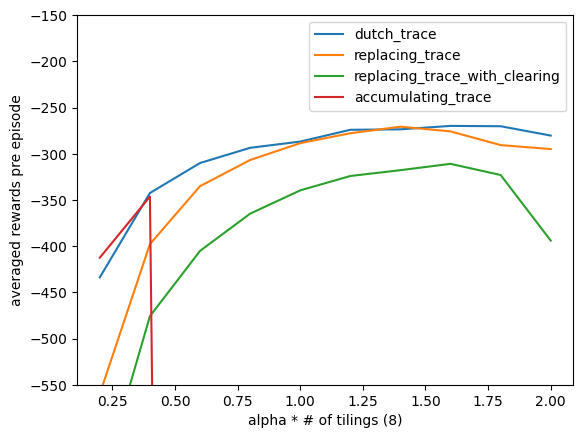

In [24]:
traceTypes = [dutch_trace, replacing_trace, replacing_trace_with_clearing, accumulating_trace]
alphas = np.arange(0.2, 2.2, 0.2)
episodes = 20
runs = 30
lam = 0.9
rewards = np.zeros((len(traceTypes), len(alphas), runs, episodes))

for traceInd, trace in enumerate(traceTypes):
    for alphaInd, alpha in enumerate(alphas):
        for run in tqdm(range(runs)):
            evaluator = Sarsa(alpha, lam, trace)
            for ep in range(episodes):
                if trace == accumulating_trace and alpha > 0.6:
                    steps = STEP_LIMIT
                else:
                    steps = play(evaluator)
                rewards[traceInd, alphaInd, run, ep] = -steps

# average over episodes
rewards = np.mean(rewards, axis=3)

# average over runs
rewards = np.mean(rewards, axis=2)

for traceInd, trace in enumerate(traceTypes):
    plt.plot(alphas, rewards[traceInd, :], label=trace.__name__)
plt.xlabel('alpha * # of tilings (8)')
plt.ylabel('averaged rewards pre episode')
plt.ylim([-550, -150])
plt.legend()

plt.show()
plt.close()